# Q-Learning

In [22]:
!pip install gym_anytrading

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv, Actions, Positions
from gym_anytrading.datasets import STOCKS_GOOGL

## 2. Discretizer Class

In [11]:
# Define discretization parameters
class Discretizer:
    def __init__(self, lower_bounds, upper_bounds, num_bins):
        """
        Initialize the discretizer for continuous state space
        
        Args:
            lower_bounds: Lower bounds for each dimension of the observation space
            upper_bounds: Upper bounds for each dimension of the observation space
            num_bins: Number of bins for each dimension
        """
        self.lower_bounds = np.array(lower_bounds)
        self.upper_bounds = np.array(upper_bounds)
        self.num_bins = np.array(num_bins)
        self.bin_sizes = (upper_bounds - lower_bounds) / num_bins
    
    def discretize(self, observation):
        """
        Convert a continuous observation to a discrete state
        
        Args:
            observation: Continuous observation from the environment
            
        Returns:
            A tuple representing the discretized state
        """
        # Clip the observation to be within bounds
        clipped_obs = np.clip(observation, self.lower_bounds, self.upper_bounds)
        
        # Calculate the bin indices for each dimension
        bin_indices = np.floor((clipped_obs - self.lower_bounds) / self.bin_sizes).astype(int)
        
        # Ensure indices are within valid range
        bin_indices = np.clip(bin_indices, 0, self.num_bins - 1)
        
        # Convert multi-dimensional indices to a single index
        # We'll use a tuple for the state representation
        return tuple(map(int, bin_indices.flatten()))

## 3.1. Q-Learning Agent Class (Epsilon-Greedy)

In [7]:
# Q-Learning Agent
class QLearningAgent:
    def __init__(self, action_space, discretizer, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.02):
        """
        Initialize the Q-Learning agent
        
        Args:
            action_space: The action space of the environment
            discretizer: The discretizer to convert continuous observations to discrete states
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            exploration_rate: Initial exploration rate (epsilon)
            exploration_decay: Rate at which exploration rate decays
            min_exploration_rate: Minimum exploration rate
        """
        self.action_space = action_space
        self.discretizer = discretizer
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        
        # Initialize Q-table with zeros
        self.q_table = {}
    
    def get_action(self, observation):
        """
        Choose an action using epsilon-greedy policy
        
        Args:
            observation: The current observation from the environment
            
        Returns:
            The selected action
        """
        # Discretize the observation
        state = self.discretizer.discretize(observation)
        
        # Epsilon-greedy action selection
        if np.random.random() < self.exploration_rate:
            # Explore: choose a random action
            return self.action_space.sample()
        else:
            # Exploit: choose the best action from Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(self.action_space.n)
            
            # Return the action with the highest Q-value
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """
        Update the Q-table using the Q-learning update rule
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether the episode is done
        """
        # Discretize states
        discrete_state = self.discretizer.discretize(state)
        discrete_next_state = self.discretizer.discretize(next_state)
        
        # Initialize Q-values if not in table
        if discrete_state not in self.q_table:
            self.q_table[discrete_state] = np.zeros(self.action_space.n)
        
        if discrete_next_state not in self.q_table:
            self.q_table[discrete_next_state] = np.zeros(self.action_space.n)
        
        # Q-learning update rule
        best_next_action = np.argmax(self.q_table[discrete_next_state])
        td_target = reward + (1 - int(done)) * self.discount_factor * self.q_table[discrete_next_state][best_next_action]
        td_error = td_target - self.q_table[discrete_state][action]
        self.q_table[discrete_state][action] += self.learning_rate * td_error
        
        # Decay exploration rate
        if done:
            self.exploration_rate = max(self.min_exploration_rate, 
                                        self.exploration_rate * self.exploration_decay)

### 3.1.a. Learning Rate = 0.1

Episode 10/10000, Avg Reward: 25.04, Avg Profit: 0.6448, Exploration Rate: 0.9511
Episode 20/10000, Avg Reward: 23.77, Avg Profit: 0.6439, Exploration Rate: 0.9046
Episode 30/10000, Avg Reward: 28.62, Avg Profit: 0.6424, Exploration Rate: 0.8604
Episode 40/10000, Avg Reward: 28.49, Avg Profit: 0.6404, Exploration Rate: 0.8183
Episode 50/10000, Avg Reward: 20.00, Avg Profit: 0.6223, Exploration Rate: 0.7783
Episode 60/10000, Avg Reward: 28.26, Avg Profit: 0.6488, Exploration Rate: 0.7403
Episode 70/10000, Avg Reward: 26.77, Avg Profit: 0.6381, Exploration Rate: 0.7041
Episode 80/10000, Avg Reward: 29.44, Avg Profit: 0.6586, Exploration Rate: 0.6696
Episode 90/10000, Avg Reward: 34.79, Avg Profit: 0.6754, Exploration Rate: 0.6369
Episode 100/10000, Avg Reward: 20.77, Avg Profit: 0.6547, Exploration Rate: 0.6058
Episode 110/10000, Avg Reward: 21.88, Avg Profit: 0.6568, Exploration Rate: 0.5762
Episode 120/10000, Avg Reward: 19.69, Avg Profit: 0.6504, Exploration Rate: 0.5480
Episode 130/1

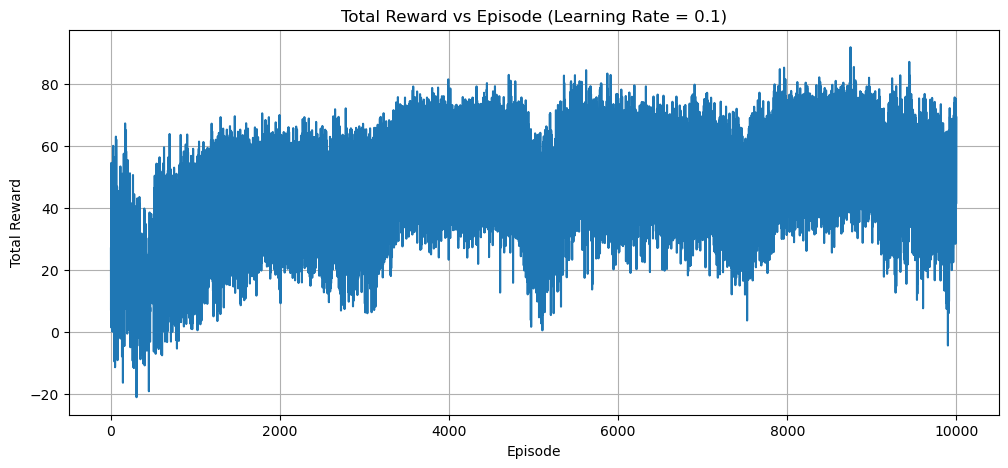


Evaluating trained agent (Learning Rate = 0.1)...
Evaluation - Total Reward: 75.64, Total Profit: 0.8449


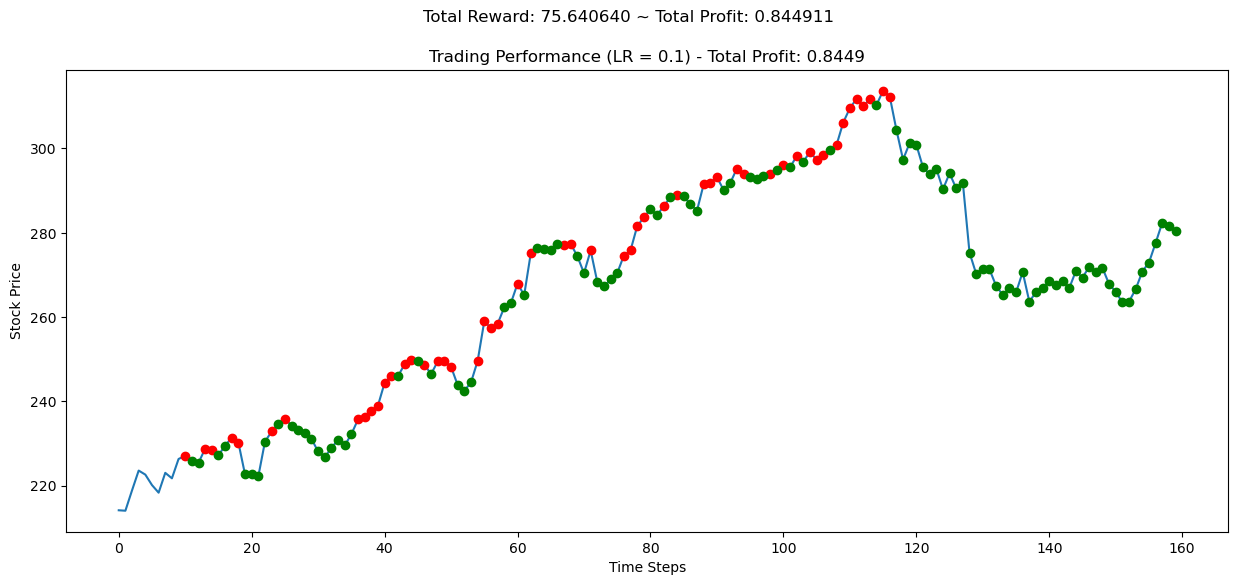

In [ ]:
# Main function with learning_rate = 0.1
def main_lr_01():
    # Create the environment
    window_size = 10
    env = gym.make('stocks-v0', frame_bound=(50, 200), window_size=window_size)
    
    # Get observation shape
    observation, _ = env.reset(seed=42)
    obs_shape = observation.shape
    
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # More bins for better precision
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # More bins for better precision
    
    # Create arrays for each dimension
    lower_bounds = np.array([[price_lower, diff_lower]] * window_size)
    upper_bounds = np.array([[price_upper, diff_upper]] * window_size)
    num_bins = np.array([[price_bins, diff_bins]] * window_size)
    
    # Create discretizer
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent with learning_rate = 0.1
    agent = QLearningAgent(
        action_space=env.action_space,
        discretizer=discretizer,
        learning_rate=0.1,  # Learning rate = 0.1
        discount_factor=0.99,
        exploration_rate=1.0,
        exploration_decay=0.995,
        min_exploration_rate=0.02
    )
    
    # Training parameters
    num_episodes = 10000
    max_steps = 1000
    
    # Lists to store metrics
    episode_rewards = []
    episode_profits = []
    
    # Training loop
    for episode in range(num_episodes):
        # Reset the environment
        observation, _ = env.reset(seed=episode)
        total_reward = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            total_reward += reward
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        episode_profits.append(info['total_profit'])
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            print(f"Episode {episode + 1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}, Exploration Rate: {agent.exploration_rate:.4f}")
    
    # Plot training results - Total Reward vs Episode
    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards)
    plt.title('Total Reward vs Episode (Learning Rate = 0.1)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # Create results directory if it doesn't exist
    import os
    results_dir = os.path.join('results', 'epsilon-greedy', 'lr01')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_rewards_lr01.png'))
    plt.show()
    
    # Evaluate the trained agent
    print("\nEvaluating trained agent (Learning Rate = 0.1)...")
    observation, _ = env.reset(seed=1000)  # Different seed for evaluation
    done = False
    total_reward = 0
    
    while not done:
        # Choose action (no exploration during evaluation)
        state = discretizer.discretize(observation)
        if state in agent.q_table:
            action = np.argmax(agent.q_table[state])
        else:
            action = env.action_space.sample()
        
        # Take action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Evaluation - Total Reward: {total_reward:.2f}, Total Profit: {info['total_profit']:.4f}")
    
    # Render the trading performance
    plt.figure(figsize=(15, 6))
    env.unwrapped.render_all()
    plt.title(f"Trading Performance (LR = 0.1) - Total Profit: {info['total_profit']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_trading_performance_lr01.png'))
    plt.show()
    
    # Return results for comparison
    return {
        'learning_rate': 0.1,
        'episode_rewards': episode_rewards,
        'episode_profits': episode_profits,
        'final_avg_reward': np.mean(episode_rewards[-100:]),
        'final_avg_profit': np.mean(episode_profits[-100:])
    }

# Run the experiment with learning_rate = 0.1
results_lr_01 = main_lr_01()

### 3.1.b. Learning Rate = 0.01

Episode 10/10000, Avg Reward: 30.48, Avg Profit: 0.6597, Exploration Rate: 0.9511
Episode 20/10000, Avg Reward: 32.75, Avg Profit: 0.6566, Exploration Rate: 0.9046
Episode 30/10000, Avg Reward: 31.70, Avg Profit: 0.6422, Exploration Rate: 0.8604
Episode 40/10000, Avg Reward: 30.29, Avg Profit: 0.6418, Exploration Rate: 0.8183
Episode 50/10000, Avg Reward: 13.40, Avg Profit: 0.5981, Exploration Rate: 0.7783
Episode 60/10000, Avg Reward: 24.27, Avg Profit: 0.6346, Exploration Rate: 0.7403
Episode 70/10000, Avg Reward: 23.06, Avg Profit: 0.6255, Exploration Rate: 0.7041
Episode 80/10000, Avg Reward: 25.93, Avg Profit: 0.6315, Exploration Rate: 0.6696
Episode 90/10000, Avg Reward: 14.60, Avg Profit: 0.6381, Exploration Rate: 0.6369
Episode 100/10000, Avg Reward: 28.14, Avg Profit: 0.6652, Exploration Rate: 0.6058
Episode 110/10000, Avg Reward: 32.24, Avg Profit: 0.6602, Exploration Rate: 0.5762
Episode 120/10000, Avg Reward: 30.27, Avg Profit: 0.6867, Exploration Rate: 0.5480
Episode 130/1

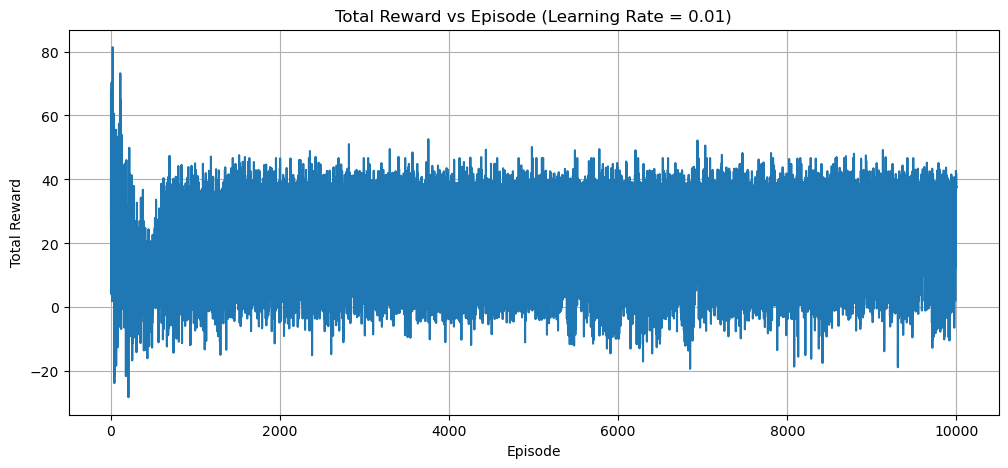


Evaluating trained agent (Learning Rate = 0.01)...
Evaluation - Total Reward: 37.29, Total Profit: 0.8190


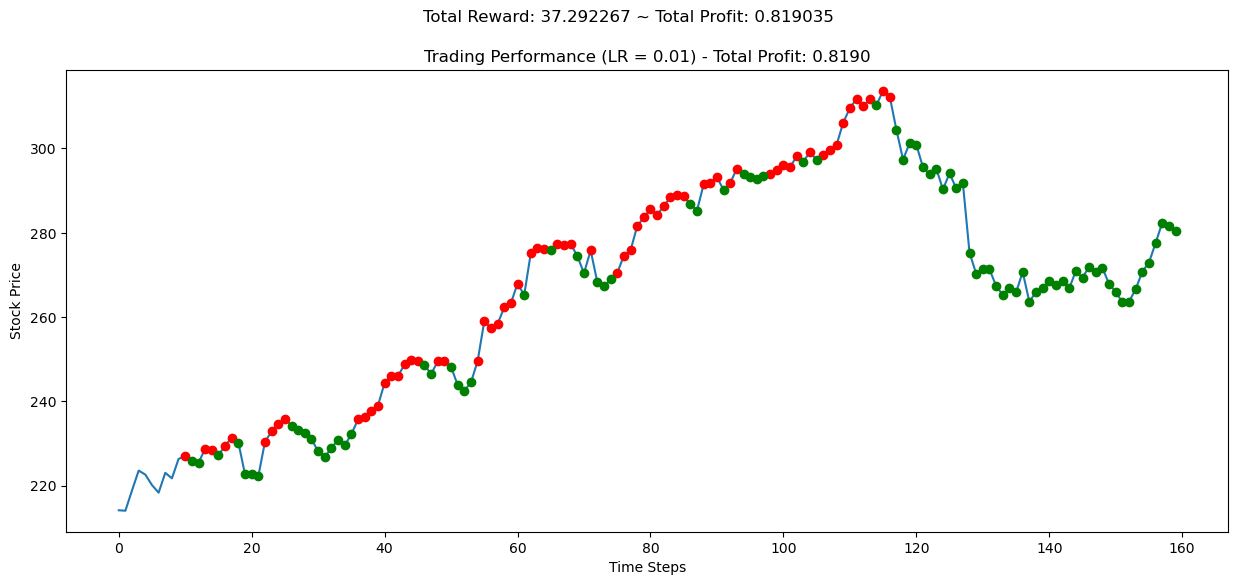

In [ ]:
# Main function with learning_rate = 0.01
def main_lr_001():
    # Create the environment
    window_size = 10
    env = gym.make('stocks-v0', frame_bound=(50, 200), window_size=window_size)
    
    # Get observation shape
    observation, _ = env.reset(seed=42)
    obs_shape = observation.shape
    
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # More bins for better precision
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # More bins for better precision
    
    # Create arrays for each dimension
    lower_bounds = np.array([[price_lower, diff_lower]] * window_size)
    upper_bounds = np.array([[price_upper, diff_upper]] * window_size)
    num_bins = np.array([[price_bins, diff_bins]] * window_size)
    
    # Create discretizer
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent with learning_rate = 0.01
    agent = QLearningAgent(
        action_space=env.action_space,
        discretizer=discretizer,
        learning_rate=0.01,  # Learning rate = 0.01
        discount_factor=0.99,
        exploration_rate=1.0,
        exploration_decay=0.995,
        min_exploration_rate=0.02
    )
    
    # Training parameters
    num_episodes = 10000
    max_steps = 1000
    
    # Lists to store metrics
    episode_rewards = []
    episode_profits = []
    
    # Training loop
    for episode in range(num_episodes):
        # Reset the environment
        observation, _ = env.reset(seed=episode)
        total_reward = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            total_reward += reward
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        episode_profits.append(info['total_profit'])
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            print(f"Episode {episode + 1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}, Exploration Rate: {agent.exploration_rate:.4f}")
    
    # Plot training results - Total Reward vs Episode
    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards)
    plt.title('Total Reward vs Episode (Learning Rate = 0.01)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # Create results directory if it doesn't exist
    import os
    results_dir = os.path.join('results', 'epsilon-greedy', 'lr001')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_rewards_lr001.png'))
    plt.show()
    
    # Evaluate the trained agent
    print("\nEvaluating trained agent (Learning Rate = 0.01)...")
    observation, _ = env.reset(seed=1000)  # Different seed for evaluation
    done = False
    total_reward = 0
    
    while not done:
        # Choose action (no exploration during evaluation)
        state = discretizer.discretize(observation)
        if state in agent.q_table:
            action = np.argmax(agent.q_table[state])
        else:
            action = env.action_space.sample()
        
        # Take action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Evaluation - Total Reward: {total_reward:.2f}, Total Profit: {info['total_profit']:.4f}")
    
    # Render the trading performance
    plt.figure(figsize=(15, 6))
    env.unwrapped.render_all()
    plt.title(f"Trading Performance (LR = 0.01) - Total Profit: {info['total_profit']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_trading_performance_lr001.png'))
    plt.show()
    
    # Return results for comparison
    return {
        'learning_rate': 0.01,
        'episode_rewards': episode_rewards,
        'episode_profits': episode_profits,
        'final_avg_reward': np.mean(episode_rewards[-100:]),
        'final_avg_profit': np.mean(episode_profits[-100:])
    }

# Run the experiment with learning_rate = 0.01
results_lr_001 = main_lr_001()

### 3.1.c. Learning Rate = 0.001

Episode 10/10000, Avg Reward: 26.20, Avg Profit: 0.6504, Exploration Rate: 0.9511
Episode 20/10000, Avg Reward: 29.38, Avg Profit: 0.6578, Exploration Rate: 0.9046
Episode 30/10000, Avg Reward: 32.64, Avg Profit: 0.6466, Exploration Rate: 0.8604
Episode 40/10000, Avg Reward: 30.88, Avg Profit: 0.6478, Exploration Rate: 0.8183
Episode 50/10000, Avg Reward: 36.35, Avg Profit: 0.6605, Exploration Rate: 0.7783
Episode 60/10000, Avg Reward: 23.87, Avg Profit: 0.6251, Exploration Rate: 0.7403
Episode 70/10000, Avg Reward: 33.17, Avg Profit: 0.6627, Exploration Rate: 0.7041
Episode 80/10000, Avg Reward: 36.97, Avg Profit: 0.6728, Exploration Rate: 0.6696
Episode 90/10000, Avg Reward: 33.95, Avg Profit: 0.6642, Exploration Rate: 0.6369
Episode 100/10000, Avg Reward: 21.05, Avg Profit: 0.6322, Exploration Rate: 0.6058
Episode 110/10000, Avg Reward: 30.70, Avg Profit: 0.6730, Exploration Rate: 0.5762
Episode 120/10000, Avg Reward: 30.40, Avg Profit: 0.6701, Exploration Rate: 0.5480
Episode 130/1

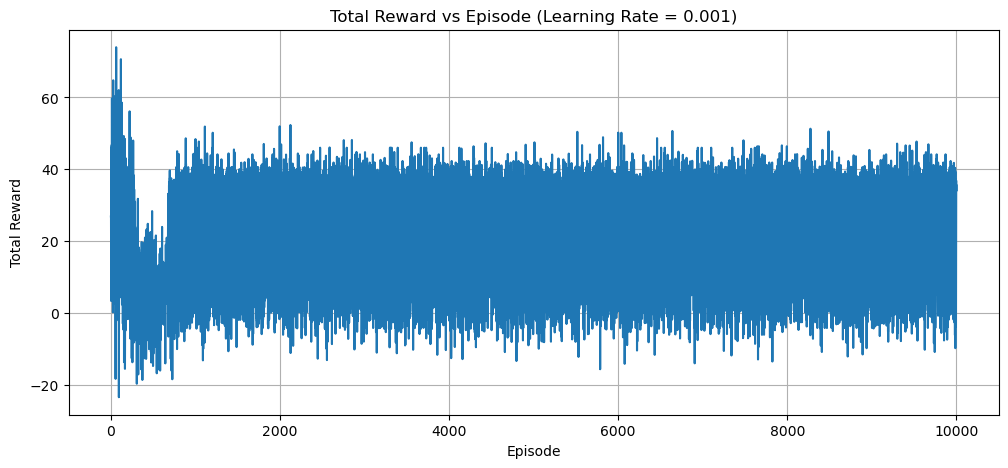


Evaluating trained agent (Learning Rate = 0.001)...
Evaluation - Total Reward: 36.62, Total Profit: 0.8165


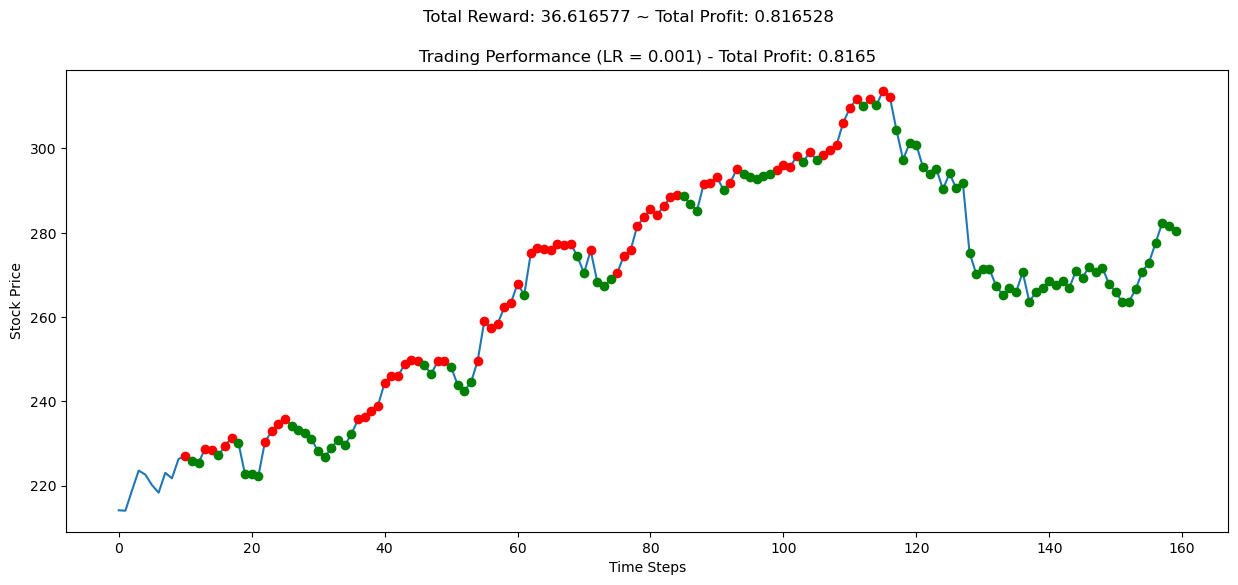

In [ ]:
# Main function with learning_rate = 0.001
def main_lr_0001():
    # Create the environment
    window_size = 10
    env = gym.make('stocks-v0', frame_bound=(50, 200), window_size=window_size)
    
    # Get observation shape
    observation, _ = env.reset(seed=42)
    obs_shape = observation.shape
    
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # More bins for better precision
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # More bins for better precision
    
    # Create arrays for each dimension
    lower_bounds = np.array([[price_lower, diff_lower]] * window_size)
    upper_bounds = np.array([[price_upper, diff_upper]] * window_size)
    num_bins = np.array([[price_bins, diff_bins]] * window_size)
    
    # Create discretizer
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent with learning_rate = 0.001
    agent = QLearningAgent(
        action_space=env.action_space,
        discretizer=discretizer,
        learning_rate=0.001,  # Learning rate = 0.001
        discount_factor=0.99,
        exploration_rate=1.0,
        exploration_decay=0.995,
        min_exploration_rate=0.02
    )
    
    # Training parameters
    num_episodes = 10000
    max_steps = 1000
    
    # Lists to store metrics
    episode_rewards = []
    episode_profits = []
    
    # Training loop
    for episode in range(num_episodes):
        # Reset the environment
        observation, _ = env.reset(seed=episode)
        total_reward = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            total_reward += reward
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        episode_profits.append(info['total_profit'])
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            print(f"Episode {episode + 1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}, Exploration Rate: {agent.exploration_rate:.4f}")
    
    # Plot training results - Total Reward vs Episode
    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards)
    plt.title('Total Reward vs Episode (Learning Rate = 0.001)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # Create results directory if it doesn't exist
    import os
    results_dir = os.path.join('results', 'epsilon-greedy', 'lr0001')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_rewards_lr0001.png'))
    plt.show()
    
    # Evaluate the trained agent
    print("\nEvaluating trained agent (Learning Rate = 0.001)...")
    observation, _ = env.reset(seed=1000)  # Different seed for evaluation
    done = False
    total_reward = 0
    
    while not done:
        # Choose action (no exploration during evaluation)
        state = discretizer.discretize(observation)
        if state in agent.q_table:
            action = np.argmax(agent.q_table[state])
        else:
            action = env.action_space.sample()
        
        # Take action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Evaluation - Total Reward: {total_reward:.2f}, Total Profit: {info['total_profit']:.4f}")
    
    # Render the trading performance
    plt.figure(figsize=(15, 6))
    env.unwrapped.render_all()
    plt.title(f"Trading Performance (LR = 0.001) - Total Profit: {info['total_profit']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_trading_performance_lr0001.png'))
    plt.show()
    
    # Return results for comparison
    return {
        'learning_rate': 0.001,
        'episode_rewards': episode_rewards,
        'episode_profits': episode_profits,
        'final_avg_reward': np.mean(episode_rewards[-100:]),
        'final_avg_profit': np.mean(episode_profits[-100:])
    }

# Run the experiment with learning_rate = 0.001
results_lr_0001 = main_lr_0001()

### 3.1.d. Comparison

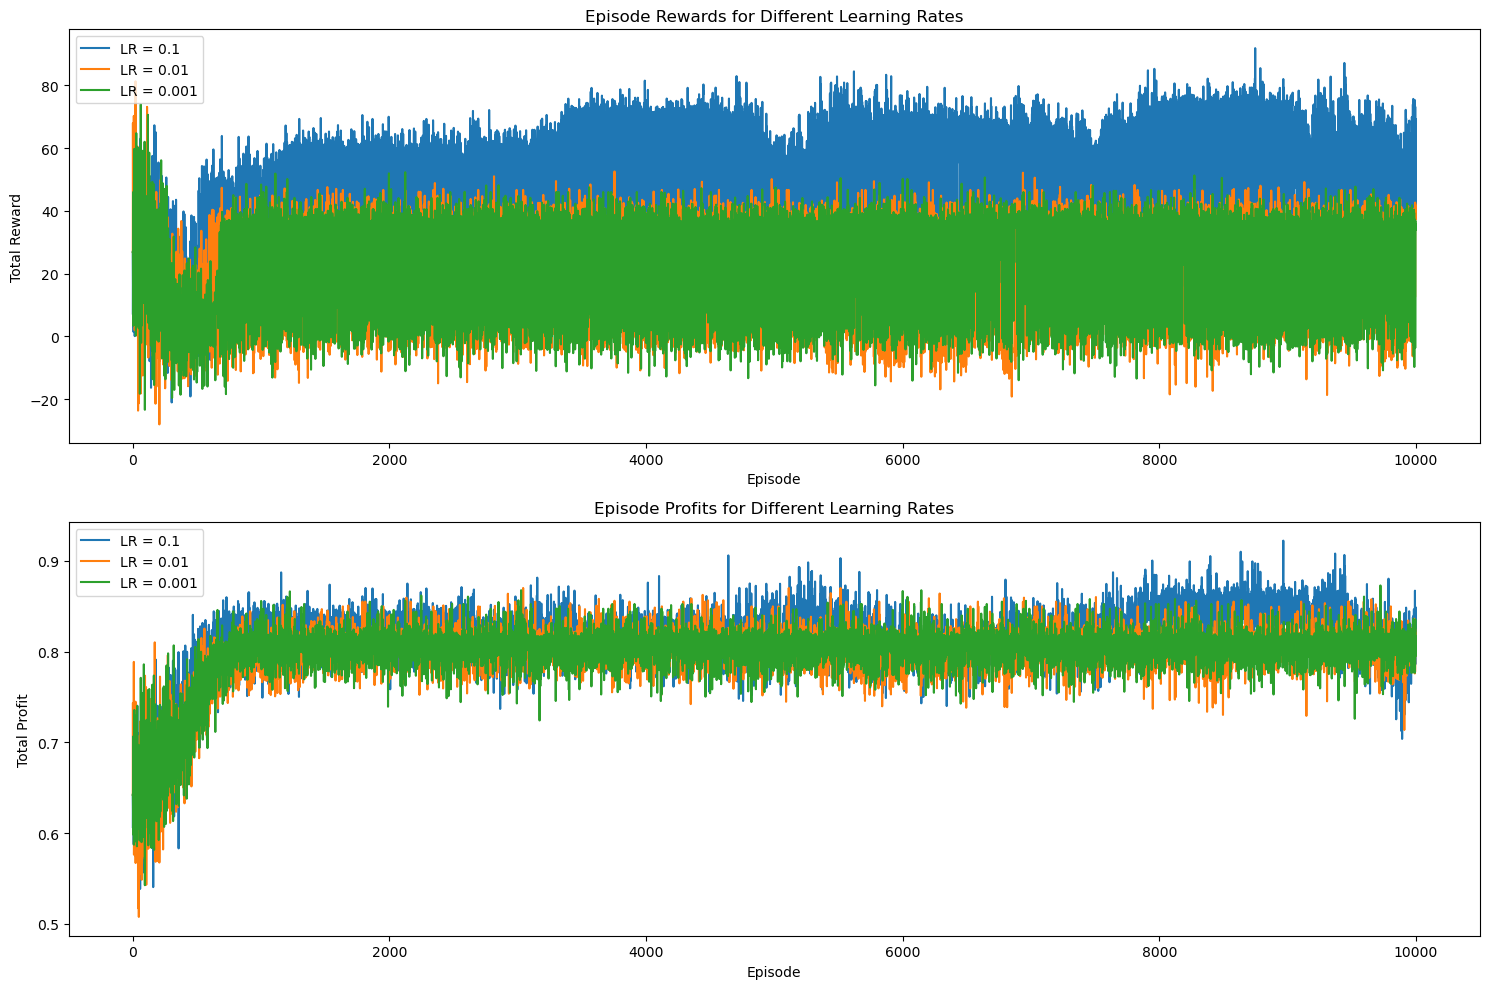


Summary of Results:
Learning Rate = 0.1:   Avg Reward = 53.53, Avg Profit = 0.8017
Learning Rate = 0.01:  Avg Reward = 25.69, Avg Profit = 0.8022
Learning Rate = 0.001: Avg Reward = 24.59, Avg Profit = 0.8076


In [ ]:
# Compare results from different learning rates
plt.figure(figsize=(15, 10))

# Plot rewards
plt.subplot(2, 1, 1)
plt.plot(results_lr_01['episode_rewards'], label='LR = 0.1')
plt.plot(results_lr_001['episode_rewards'], label='LR = 0.01')
plt.plot(results_lr_0001['episode_rewards'], label='LR = 0.001')
plt.title('Episode Rewards for Different Learning Rates')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

# Plot profits
plt.subplot(2, 1, 2)
plt.plot(results_lr_01['episode_profits'], label='LR = 0.1')
plt.plot(results_lr_001['episode_profits'], label='LR = 0.01')
plt.plot(results_lr_0001['episode_profits'], label='LR = 0.001')
plt.title('Episode Profits for Different Learning Rates')
plt.xlabel('Episode')
plt.ylabel('Total Profit')
plt.legend()

plt.tight_layout()

# Create results directory if it doesn't exist
import os
results_dir = os.path.join('results', 'epsilon-greedy')
os.makedirs(results_dir, exist_ok=True)

# Save figure to the specified directory
plt.savefig(os.path.join(results_dir, 'learning_rate_comparison.png'))
plt.show()

# Print summary of results
print("\nSummary of Results:")
print(f"Learning Rate = 0.1:   Avg Reward = {results_lr_01['final_avg_reward']:.2f}, Avg Profit = {results_lr_01['final_avg_profit']:.4f}")
print(f"Learning Rate = 0.01:  Avg Reward = {results_lr_001['final_avg_reward']:.2f}, Avg Profit = {results_lr_001['final_avg_profit']:.4f}")
print(f"Learning Rate = 0.001: Avg Reward = {results_lr_0001['final_avg_reward']:.2f}, Avg Profit = {results_lr_0001['final_avg_profit']:.4f}")

## 3.2. Q-Learning Agent Class (Thompson Sampling)

In [10]:
# Q-Learning Agent with Thompson Sampling exploration
class QLearningAgentThompson:
    def __init__(self, action_space, discretizer, learning_rate=0.1, discount_factor=0.99, alpha_prior=1.0, beta_prior=1.0):
        """
        Initialize the Q-Learning agent with Thompson Sampling exploration
        
        Args:
            action_space: The action space of the environment
            discretizer: The discretizer to convert continuous observations to discrete states
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            alpha_prior: Alpha parameter for the Beta distribution prior
            beta_prior: Beta parameter for the Beta distribution prior
        """
        self.action_space = action_space
        self.discretizer = discretizer
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior
        
        # Initialize Q-table with zeros
        self.q_table = {}
        
        # Initialize success and failure counts for each state-action pair
        self.success_count = {}
        self.failure_count = {}
        
        # Normalize rewards to [0, 1] for Beta distribution
        self.max_reward_seen = 1.0
        self.min_reward_seen = 0.0
    
    def get_action(self, observation):
        """
        Choose an action using Thompson Sampling policy
        
        Args:
            observation: The current observation from the environment
            
        Returns:
            The selected action
        """
        # Discretize the observation
        state = self.discretizer.discretize(observation)
        
        # Initialize state if not in tables
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
            self.success_count[state] = np.ones(self.action_space.n) * self.alpha_prior
            self.failure_count[state] = np.ones(self.action_space.n) * self.beta_prior
        
        # Sample from Beta distribution for each action
        samples = np.zeros(self.action_space.n)
        for a in range(self.action_space.n):
            # Thompson sampling: sample from Beta distribution
            samples[a] = np.random.beta(
                self.success_count[state][a],
                self.failure_count[state][a]
            )
        
        # Choose action with highest sampled value
        return np.argmax(samples)
    
    def update(self, state, action, reward, next_state, done):
        """
        Update the Q-table using the Q-learning update rule and update Beta parameters
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether the episode is done
        """
        # Discretize states
        discrete_state = self.discretizer.discretize(state)
        discrete_next_state = self.discretizer.discretize(next_state)
        
        # Initialize Q-values if not in table
        if discrete_state not in self.q_table:
            self.q_table[discrete_state] = np.zeros(self.action_space.n)
            self.success_count[discrete_state] = np.ones(self.action_space.n) * self.alpha_prior
            self.failure_count[discrete_state] = np.ones(self.action_space.n) * self.beta_prior
        
        if discrete_next_state not in self.q_table:
            self.q_table[discrete_next_state] = np.zeros(self.action_space.n)
            self.success_count[discrete_next_state] = np.ones(self.action_space.n) * self.alpha_prior
            self.failure_count[discrete_next_state] = np.ones(self.action_space.n) * self.beta_prior
        
        # Q-learning update rule
        best_next_action = np.argmax(self.q_table[discrete_next_state])
        td_target = reward + (1 - int(done)) * self.discount_factor * self.q_table[discrete_next_state][best_next_action]
        td_error = td_target - self.q_table[discrete_state][action]
        self.q_table[discrete_state][action] += self.learning_rate * td_error
        
        # Update success and failure counts based on reward
        # Track min and max rewards to normalize
        self.max_reward_seen = max(self.max_reward_seen, reward)
        self.min_reward_seen = min(self.min_reward_seen, reward)
        
        # Normalize reward to [0, 1] range
        reward_range = max(1e-5, self.max_reward_seen - self.min_reward_seen)  # Avoid division by zero
        normalized_reward = (reward - self.min_reward_seen) / reward_range
        
        # Update Beta distribution parameters
        # Positive reward increases success count, negative reward increases failure count
        if normalized_reward > 0.5:  # Consider reward as "success" if normalized value > 0.5
            self.success_count[discrete_state][action] += normalized_reward
        else:
            self.failure_count[discrete_state][action] += (1 - normalized_reward)

### 3.2.a. Learning Rate = 0.1

Episode 10/10000, Avg Reward: 30.73, Avg Profit: 0.6927
Episode 20/10000, Avg Reward: 43.94, Avg Profit: 0.7721
Episode 30/10000, Avg Reward: 31.73, Avg Profit: 0.7745
Episode 40/10000, Avg Reward: 34.49, Avg Profit: 0.7829
Episode 50/10000, Avg Reward: 35.58, Avg Profit: 0.7969
Episode 60/10000, Avg Reward: 34.30, Avg Profit: 0.8213
Episode 70/10000, Avg Reward: 35.61, Avg Profit: 0.8266
Episode 80/10000, Avg Reward: 44.37, Avg Profit: 0.8406
Episode 90/10000, Avg Reward: 46.22, Avg Profit: 0.8423
Episode 100/10000, Avg Reward: 53.25, Avg Profit: 0.8529
Episode 110/10000, Avg Reward: 58.32, Avg Profit: 0.8380
Episode 120/10000, Avg Reward: 64.00, Avg Profit: 0.8469
Episode 130/10000, Avg Reward: 62.51, Avg Profit: 0.8352
Episode 140/10000, Avg Reward: 56.54, Avg Profit: 0.8422
Episode 150/10000, Avg Reward: 64.89, Avg Profit: 0.8592
Episode 160/10000, Avg Reward: 57.75, Avg Profit: 0.8470
Episode 170/10000, Avg Reward: 67.07, Avg Profit: 0.8592
Episode 180/10000, Avg Reward: 58.43, Av

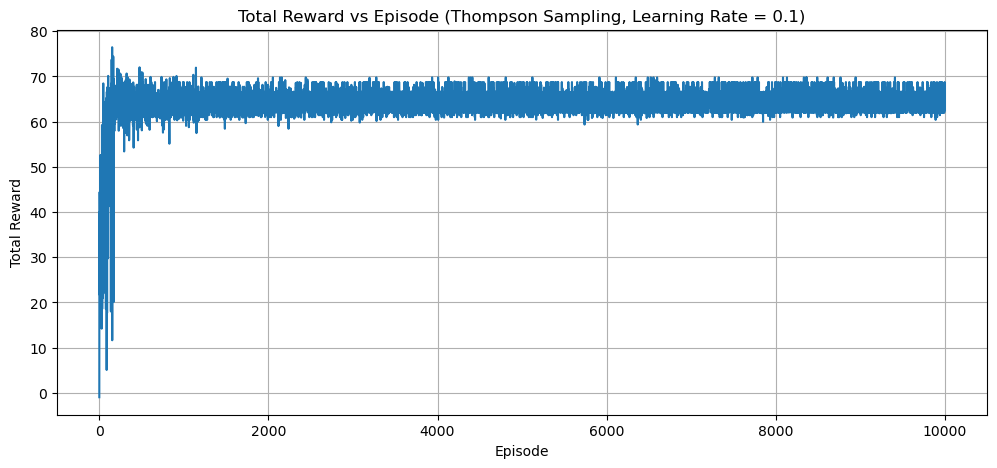


Evaluating trained agent (Thompson Sampling, Learning Rate = 0.1)...
Evaluation - Total Reward: 61.36, Total Profit: 0.8080


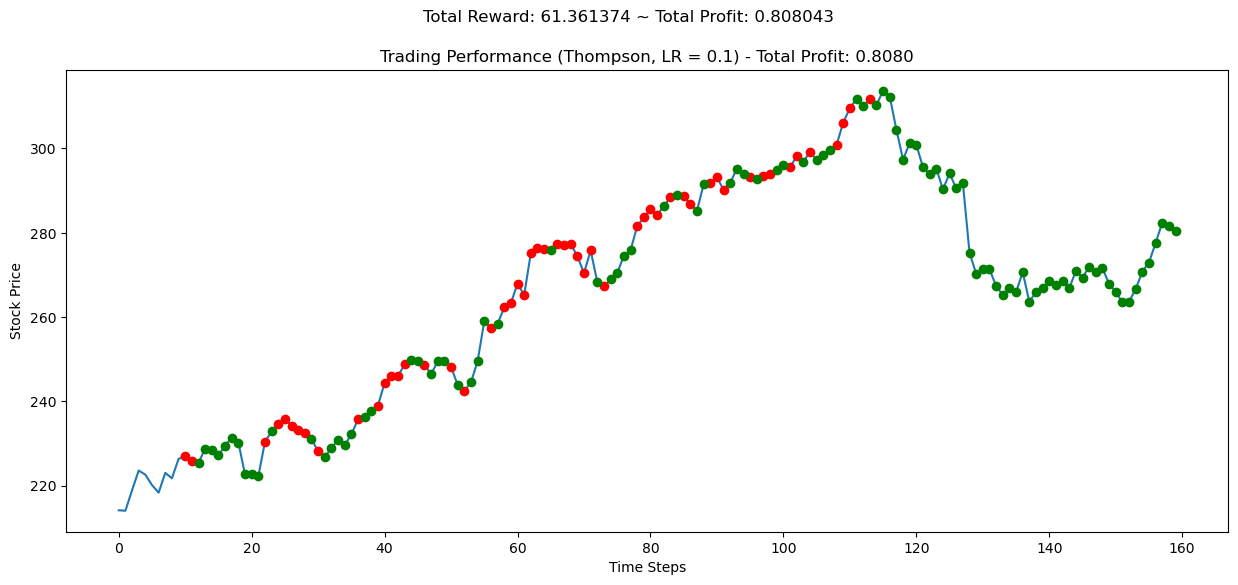

In [48]:
# Main function with Thompson Sampling and learning_rate = 0.1
def main_thompson_lr_01():
    # Create the environment
    window_size = 10
    env = gym.make('stocks-v0', frame_bound=(50, 200), window_size=window_size)
    
    # Get observation shape
    observation, _ = env.reset(seed=42)
    obs_shape = observation.shape
    
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # More bins for better precision
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # More bins for better precision
    
    # Create arrays for each dimension
    lower_bounds = np.array([[price_lower, diff_lower]] * window_size)
    upper_bounds = np.array([[price_upper, diff_upper]] * window_size)
    num_bins = np.array([[price_bins, diff_bins]] * window_size)
    
    # Create discretizer
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent with Thompson Sampling and learning_rate = 0.1
    agent = QLearningAgentThompson(
        action_space=env.action_space,
        discretizer=discretizer,
        learning_rate=0.1,  # Learning rate = 0.1
        discount_factor=0.99,
        alpha_prior=1.0,    # Prior for Beta distribution
        beta_prior=1.0      # Prior for Beta distribution
    )
    
    # Training parameters
    num_episodes = 10000
    max_steps = 1000
    
    # Lists to store metrics
    episode_rewards = []
    episode_profits = []
    
    # Training loop
    for episode in range(num_episodes):
        # Reset the environment
        observation, _ = env.reset(seed=episode)
        total_reward = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            total_reward += reward
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        episode_profits.append(info['total_profit'])
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            print(f"Episode {episode + 1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}")
    
    # Plot training results - Total Reward vs Episode
    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards)
    plt.title('Total Reward vs Episode (Thompson Sampling, Learning Rate = 0.1)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # Create results directory if it doesn't exist
    import os
    results_dir = os.path.join('results', 'thompson_sampling', 'lr01')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_thompson_rewards_lr01.png'))
    plt.show()
    
    # Evaluate the trained agent
    print("\nEvaluating trained agent (Thompson Sampling, Learning Rate = 0.1)...")
    observation, _ = env.reset(seed=1000)  # Different seed for evaluation
    done = False
    total_reward = 0
    
    while not done:
        # Choose action (using Q-values directly for evaluation, not Thompson sampling)
        state = discretizer.discretize(observation)
        if state in agent.q_table:
            action = np.argmax(agent.q_table[state])
        else:
            action = env.action_space.sample()
        
        # Take action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Evaluation - Total Reward: {total_reward:.2f}, Total Profit: {info['total_profit']:.4f}")
    
    # Render the trading performance
    plt.figure(figsize=(15, 6))
    env.unwrapped.render_all()
    plt.title(f"Trading Performance (Thompson, LR = 0.1) - Total Profit: {info['total_profit']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_thompson_trading_performance_lr01.png'))
    plt.show()
    
    return {
        'learning_rate': 0.1,
        'episode_rewards': episode_rewards,
        'episode_profits': episode_profits,
        'final_reward': total_reward,
        'final_profit': info['total_profit']
    }

# Run the experiment with Thompson Sampling and learning_rate = 0.1
results_thompson_lr_01 = main_thompson_lr_01()

### 3.2.b. Learning Rate = 0.01

Episode 10/10000, Avg Reward: 43.35, Avg Profit: 0.6897
Episode 20/10000, Avg Reward: 37.49, Avg Profit: 0.7248
Episode 30/10000, Avg Reward: 37.49, Avg Profit: 0.7500
Episode 40/10000, Avg Reward: 37.53, Avg Profit: 0.7601
Episode 50/10000, Avg Reward: 32.99, Avg Profit: 0.7559
Episode 60/10000, Avg Reward: 34.33, Avg Profit: 0.7852
Episode 70/10000, Avg Reward: 33.78, Avg Profit: 0.7866
Episode 80/10000, Avg Reward: 40.96, Avg Profit: 0.8172
Episode 90/10000, Avg Reward: 50.18, Avg Profit: 0.8313
Episode 100/10000, Avg Reward: 62.62, Avg Profit: 0.8142
Episode 110/10000, Avg Reward: 64.59, Avg Profit: 0.8255
Episode 120/10000, Avg Reward: 67.12, Avg Profit: 0.8159
Episode 130/10000, Avg Reward: 63.68, Avg Profit: 0.8231
Episode 140/10000, Avg Reward: 71.33, Avg Profit: 0.8050
Episode 150/10000, Avg Reward: 73.13, Avg Profit: 0.8288
Episode 160/10000, Avg Reward: 74.46, Avg Profit: 0.8219
Episode 170/10000, Avg Reward: 74.51, Avg Profit: 0.8319
Episode 180/10000, Avg Reward: 70.29, Av

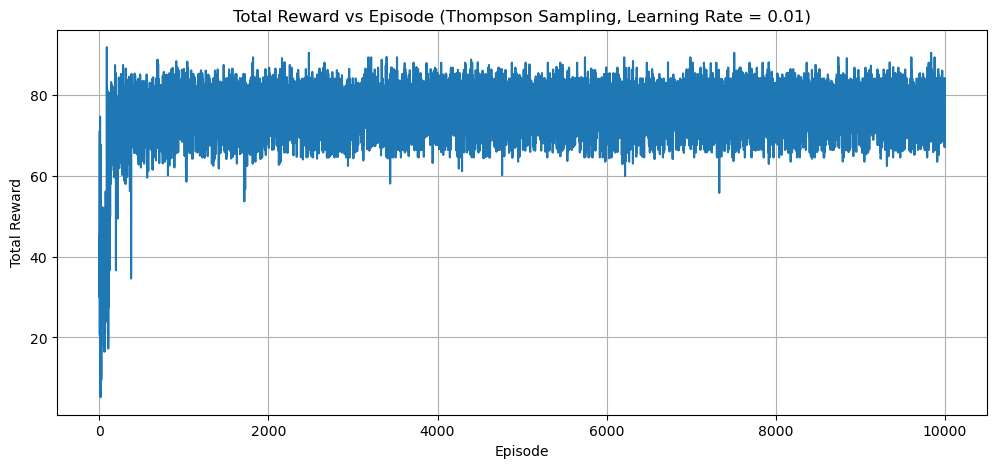


Evaluating trained agent (Thompson Sampling, Learning Rate = 0.01)...
Evaluation - Total Reward: 40.93, Total Profit: 0.8068


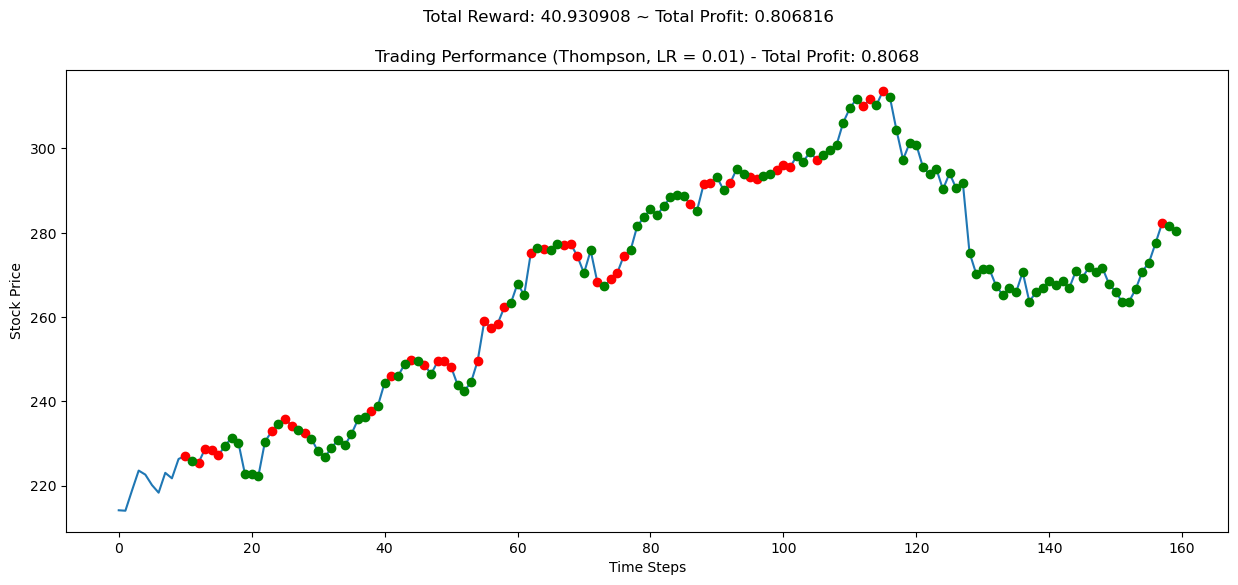

In [49]:
# Main function with Thompson Sampling and learning_rate = 0.01
def main_thompson_lr_001():
    # Create the environment
    window_size = 10
    env = gym.make('stocks-v0', frame_bound=(50, 200), window_size=window_size)
    
    # Get observation shape
    observation, _ = env.reset(seed=42)
    obs_shape = observation.shape
    
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # More bins for better precision
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # More bins for better precision
    
    # Create arrays for each dimension
    lower_bounds = np.array([[price_lower, diff_lower]] * window_size)
    upper_bounds = np.array([[price_upper, diff_upper]] * window_size)
    num_bins = np.array([[price_bins, diff_bins]] * window_size)
    
    # Create discretizer
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent with Thompson Sampling and learning_rate = 0.01
    agent = QLearningAgentThompson(
        action_space=env.action_space,
        discretizer=discretizer,
        learning_rate=0.01,  # Learning rate = 0.01
        discount_factor=0.99,
        alpha_prior=1.0,     # Prior for Beta distribution
        beta_prior=1.0       # Prior for Beta distribution
    )
    
    # Training parameters
    num_episodes = 10000
    max_steps = 1000
    
    # Lists to store metrics
    episode_rewards = []
    episode_profits = []
    
    # Training loop
    for episode in range(num_episodes):
        # Reset the environment
        observation, _ = env.reset(seed=episode)
        total_reward = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            total_reward += reward
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        episode_profits.append(info['total_profit'])
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            print(f"Episode {episode + 1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}")
    
    # Plot training results - Total Reward vs Episode
    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards)
    plt.title('Total Reward vs Episode (Thompson Sampling, Learning Rate = 0.01)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # Create results directory if it doesn't exist
    import os
    results_dir = os.path.join('results', 'thompson_sampling', 'lr001')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_thompson_rewards_lr001.png'))
    plt.show()
    
    # Evaluate the trained agent
    print("\nEvaluating trained agent (Thompson Sampling, Learning Rate = 0.01)...")
    observation, _ = env.reset(seed=1000)  # Different seed for evaluation
    done = False
    total_reward = 0
    
    while not done:
        # Choose action (using Q-values directly for evaluation, not Thompson sampling)
        state = discretizer.discretize(observation)
        if state in agent.q_table:
            action = np.argmax(agent.q_table[state])
        else:
            action = env.action_space.sample()
        
        # Take action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Evaluation - Total Reward: {total_reward:.2f}, Total Profit: {info['total_profit']:.4f}")
    
    # Render the trading performance
    plt.figure(figsize=(15, 6))
    env.unwrapped.render_all()
    plt.title(f"Trading Performance (Thompson, LR = 0.01) - Total Profit: {info['total_profit']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_thompson_trading_performance_lr001.png'))
    plt.show()
    
    return {
        'learning_rate': 0.01,
        'episode_rewards': episode_rewards,
        'episode_profits': episode_profits,
        'final_reward': total_reward,
        'final_profit': info['total_profit']
    }

# Run the experiment with Thompson Sampling and learning_rate = 0.01
results_thompson_lr_001 = main_thompson_lr_001()

### 3.2.c. Learning Rate = 0.001

Episode 10/10000, Avg Reward: 26.40, Avg Profit: 0.6493
Episode 20/10000, Avg Reward: 25.52, Avg Profit: 0.6573
Episode 30/10000, Avg Reward: 20.71, Avg Profit: 0.6639
Episode 40/10000, Avg Reward: 23.76, Avg Profit: 0.6862
Episode 50/10000, Avg Reward: 25.67, Avg Profit: 0.7037
Episode 60/10000, Avg Reward: 20.79, Avg Profit: 0.7084
Episode 70/10000, Avg Reward: 29.52, Avg Profit: 0.7414
Episode 80/10000, Avg Reward: 23.70, Avg Profit: 0.7286
Episode 90/10000, Avg Reward: 21.39, Avg Profit: 0.7270
Episode 100/10000, Avg Reward: 23.39, Avg Profit: 0.7398
Episode 110/10000, Avg Reward: 26.56, Avg Profit: 0.7409
Episode 120/10000, Avg Reward: 22.90, Avg Profit: 0.7490
Episode 130/10000, Avg Reward: 19.28, Avg Profit: 0.7455
Episode 140/10000, Avg Reward: 22.34, Avg Profit: 0.7457
Episode 150/10000, Avg Reward: 23.35, Avg Profit: 0.7580
Episode 160/10000, Avg Reward: 24.09, Avg Profit: 0.7597
Episode 170/10000, Avg Reward: 25.95, Avg Profit: 0.7715
Episode 180/10000, Avg Reward: 24.38, Av

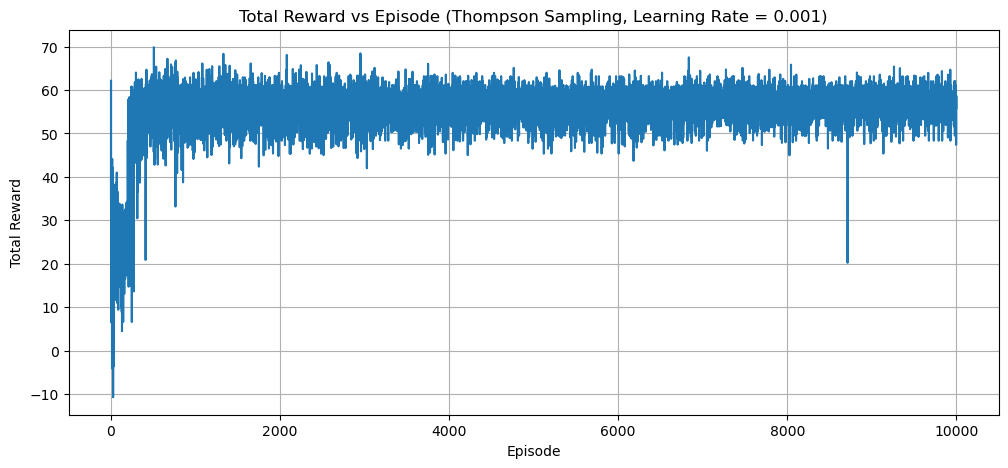


Evaluating trained agent (Thompson Sampling, Learning Rate = 0.001)...
Evaluation - Total Reward: 32.28, Total Profit: 0.8562


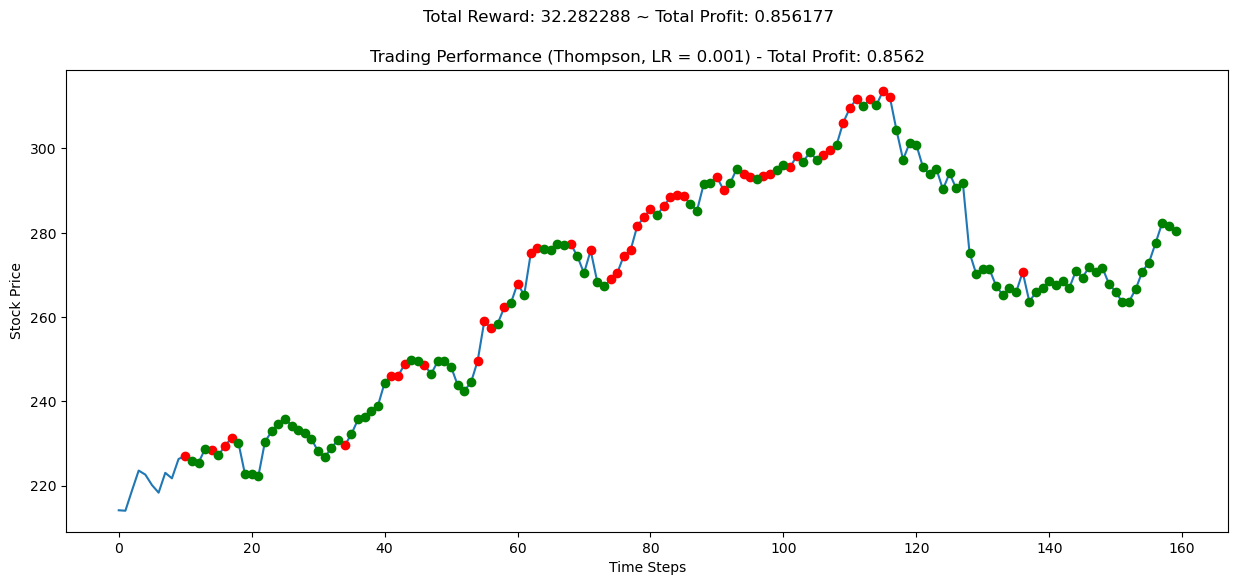

In [50]:
# Main function with Thompson Sampling and learning_rate = 0.001
def main_thompson_lr_0001():
    # Create the environment
    window_size = 10
    env = gym.make('stocks-v0', frame_bound=(50, 200), window_size=window_size)
    
    # Get observation shape
    observation, _ = env.reset(seed=42)
    obs_shape = observation.shape
    
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # More bins for better precision
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # More bins for better precision
    
    # Create arrays for each dimension
    lower_bounds = np.array([[price_lower, diff_lower]] * window_size)
    upper_bounds = np.array([[price_upper, diff_upper]] * window_size)
    num_bins = np.array([[price_bins, diff_bins]] * window_size)
    
    # Create discretizer
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent with Thompson Sampling and learning_rate = 0.001
    agent = QLearningAgentThompson(
        action_space=env.action_space,
        discretizer=discretizer,
        learning_rate=0.001,  # Learning rate = 0.001
        discount_factor=0.99,
        alpha_prior=1.0,      # Prior for Beta distribution
        beta_prior=1.0        # Prior for Beta distribution
    )
    
    # Training parameters
    num_episodes = 10000
    max_steps = 1000
    
    # Lists to store metrics
    episode_rewards = []
    episode_profits = []
    
    # Training loop
    for episode in range(num_episodes):
        # Reset the environment
        observation, _ = env.reset(seed=episode)
        total_reward = 0
        
        for step in range(max_steps):
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            total_reward += reward
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        episode_profits.append(info['total_profit'])
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            print(f"Episode {episode + 1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}")
    
    # Plot training results - Total Reward vs Episode
    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards)
    plt.title('Total Reward vs Episode (Thompson Sampling, Learning Rate = 0.001)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # Create results directory if it doesn't exist
    import os
    results_dir = os.path.join('results', 'thompson_sampling', 'lr0001')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_thompson_rewards_lr0001.png'))
    plt.show()
    
    # Evaluate the trained agent
    print("\nEvaluating trained agent (Thompson Sampling, Learning Rate = 0.001)...")
    observation, _ = env.reset(seed=1000)  # Different seed for evaluation
    done = False
    total_reward = 0
    
    while not done:
        # Choose action (using Q-values directly for evaluation, not Thompson sampling)
        state = discretizer.discretize(observation)
        if state in agent.q_table:
            action = np.argmax(agent.q_table[state])
        else:
            action = env.action_space.sample()
        
        # Take action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
    
    print(f"Evaluation - Total Reward: {total_reward:.2f}, Total Profit: {info['total_profit']:.4f}")
    
    # Render the trading performance
    plt.figure(figsize=(15, 6))
    env.unwrapped.render_all()
    plt.title(f"Trading Performance (Thompson, LR = 0.001) - Total Profit: {info['total_profit']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    
    # Save figure to the specified directory
    plt.savefig(os.path.join(results_dir, 'q_learning_thompson_trading_performance_lr0001.png'))
    plt.show()
    
    return {
        'learning_rate': 0.001,
        'episode_rewards': episode_rewards,
        'episode_profits': episode_profits,
        'final_reward': total_reward,
        'final_profit': info['total_profit']
    }

# Run the experiment with Thompson Sampling and learning_rate = 0.001
results_thompson_lr_0001 = main_thompson_lr_0001()

### 3.2.d. Comparison

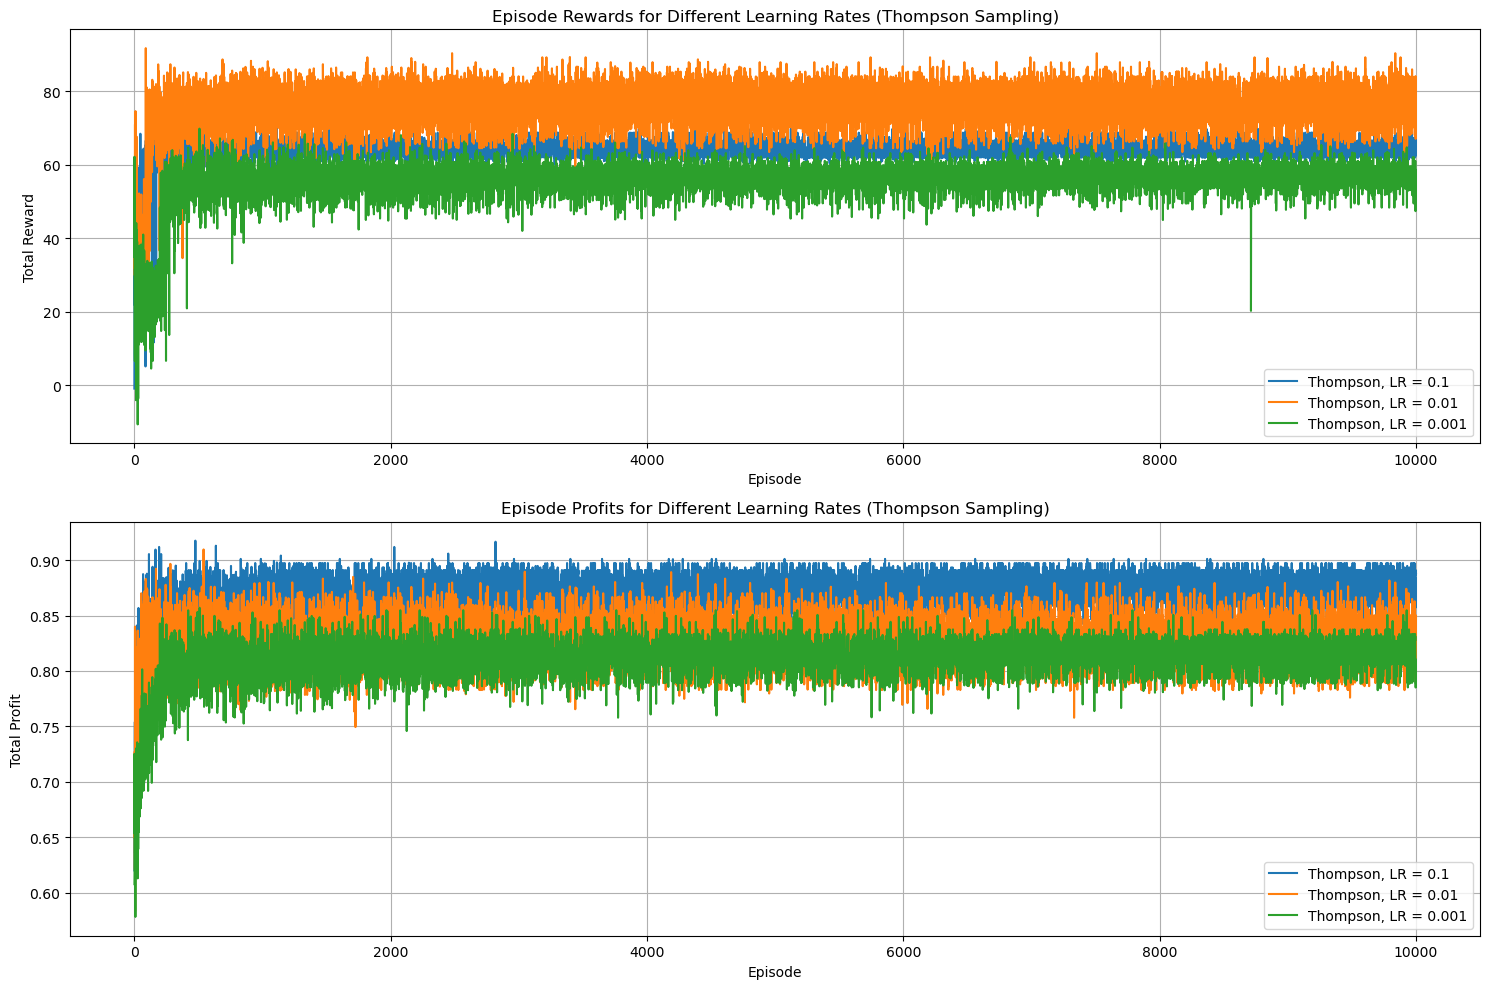


Summary of Thompson Sampling Results:
Learning Rate = 0.1:   Final Reward = 61.36, Final Profit = 0.8080
Learning Rate = 0.01:  Final Reward = 40.93, Final Profit = 0.8068
Learning Rate = 0.001: Final Reward = 32.28, Final Profit = 0.8562


In [51]:
# Compare results from different Thompson Sampling learning rates
plt.figure(figsize=(15, 10))

# Plot rewards
plt.subplot(2, 1, 1)
plt.plot(results_thompson_lr_01['episode_rewards'], label='Thompson, LR = 0.1')
plt.plot(results_thompson_lr_001['episode_rewards'], label='Thompson, LR = 0.01')
plt.plot(results_thompson_lr_0001['episode_rewards'], label='Thompson, LR = 0.001')
plt.title('Episode Rewards for Different Learning Rates (Thompson Sampling)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

# Plot profits
plt.subplot(2, 1, 2)
plt.plot(results_thompson_lr_01['episode_profits'], label='Thompson, LR = 0.1')
plt.plot(results_thompson_lr_001['episode_profits'], label='Thompson, LR = 0.01')
plt.plot(results_thompson_lr_0001['episode_profits'], label='Thompson, LR = 0.001')
plt.title('Episode Profits for Different Learning Rates (Thompson Sampling)')
plt.xlabel('Episode')
plt.ylabel('Total Profit')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Create results directory if it doesn't exist
import os
results_dir = os.path.join('results', 'thompson_sampling')
os.makedirs(results_dir, exist_ok=True)

# Save figure to the specified directory
plt.savefig(os.path.join(results_dir, 'thompson_learning_rate_comparison.png'))
plt.show()

# Print summary of results
print("\nSummary of Thompson Sampling Results:")
print(f"Learning Rate = 0.1:   Final Reward = {results_thompson_lr_01['final_reward']:.2f}, Final Profit = {results_thompson_lr_01['final_profit']:.4f}")
print(f"Learning Rate = 0.01:  Final Reward = {results_thompson_lr_001['final_reward']:.2f}, Final Profit = {results_thompson_lr_001['final_profit']:.4f}")
print(f"Learning Rate = 0.001: Final Reward = {results_thompson_lr_0001['final_reward']:.2f}, Final Profit = {results_thompson_lr_0001['final_profit']:.4f}")

## 4. Reward Structures

In [12]:
def discretize(self, observation):
    """
    Convert a continuous observation to a discrete state
    
    Args:
        observation: Continuous observation from the environment
        
    Returns:
        A tuple representing the discretized state
    """
    # Handle different observation types
    if isinstance(observation, tuple):
        # If observation is a tuple, extract the first element (actual observation)
        observation = observation[0]
    
    # For trading environment, we'll use the last row (most recent data)
    if len(observation.shape) > 1:
        # If observation is 2D (window_size, features), take the last row
        flat_obs = observation[-1]
    else:
        # If observation is already 1D, use it directly
        flat_obs = observation
    
    # Ensure the flattened observation matches the expected dimensions
    if len(flat_obs) != len(self.lower_bounds):
        # If dimensions still don't match, truncate or pad
        if len(flat_obs) > len(self.lower_bounds):
            flat_obs = flat_obs[:len(self.lower_bounds)]
        else:
            # This should not happen with our setup, but just in case
            flat_obs = np.pad(flat_obs, (0, len(self.lower_bounds) - len(flat_obs)), 'constant')
    
    # Clip the observation to be within bounds
    clipped_obs = np.clip(flat_obs, self.lower_bounds, self.upper_bounds)
    
    # Calculate the bin indices for each dimension
    bin_indices = np.floor((clipped_obs - self.lower_bounds) / self.bin_sizes).astype(int)
    
    # Ensure indices are within valid range
    bin_indices = np.clip(bin_indices, 0, self.num_bins - 1)
    
    # Convert multi-dimensional indices to a single index
    # We'll use a tuple for the state representation
    return tuple(map(int, bin_indices.flatten()))


=== Training with default reward structure ===

Episode 10/10000, Avg Reward: 8.29, Avg Profit: 0.3662, Exploration Rate: 0.9511
Episode 20/10000, Avg Reward: 34.41, Avg Profit: 0.3970, Exploration Rate: 0.9046
Episode 30/10000, Avg Reward: 15.42, Avg Profit: 0.3718, Exploration Rate: 0.8604
Episode 40/10000, Avg Reward: 20.18, Avg Profit: 0.3940, Exploration Rate: 0.8183
Episode 50/10000, Avg Reward: 36.24, Avg Profit: 0.4154, Exploration Rate: 0.7783
Episode 60/10000, Avg Reward: 31.60, Avg Profit: 0.4007, Exploration Rate: 0.7403
Episode 70/10000, Avg Reward: 45.83, Avg Profit: 0.4222, Exploration Rate: 0.7041
Episode 80/10000, Avg Reward: 43.81, Avg Profit: 0.4207, Exploration Rate: 0.6696
Episode 90/10000, Avg Reward: 36.57, Avg Profit: 0.4152, Exploration Rate: 0.6369
Episode 100/10000, Avg Reward: 36.07, Avg Profit: 0.4133, Exploration Rate: 0.6058
Episode 110/10000, Avg Reward: 31.98, Avg Profit: 0.4272, Exploration Rate: 0.5762
Episode 120/10000, Avg Reward: 31.56, Avg Profit

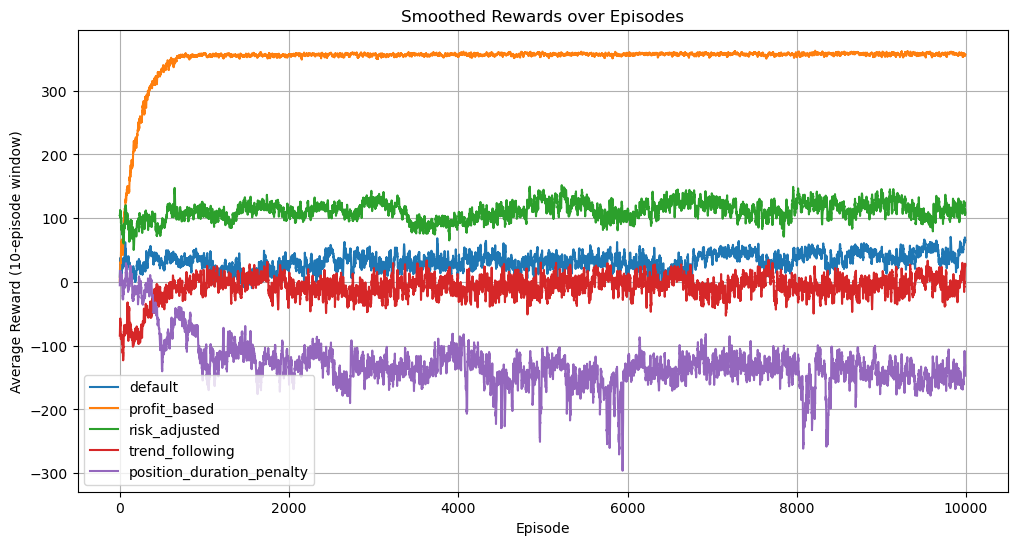

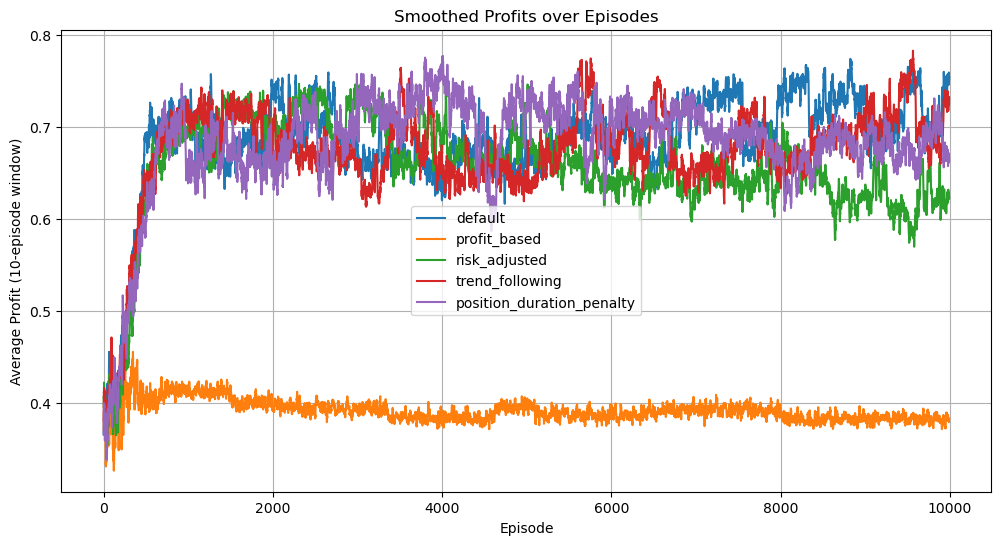

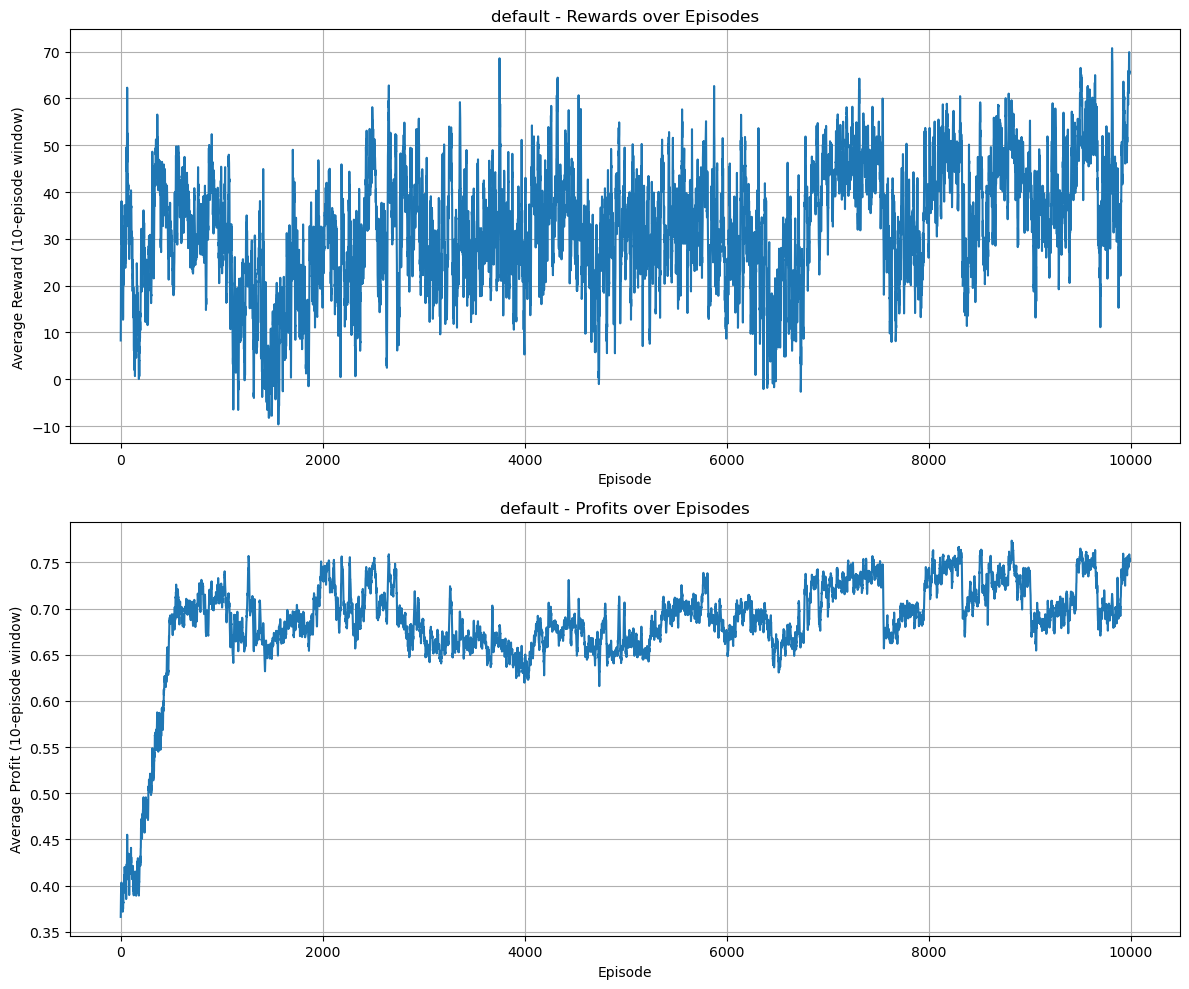

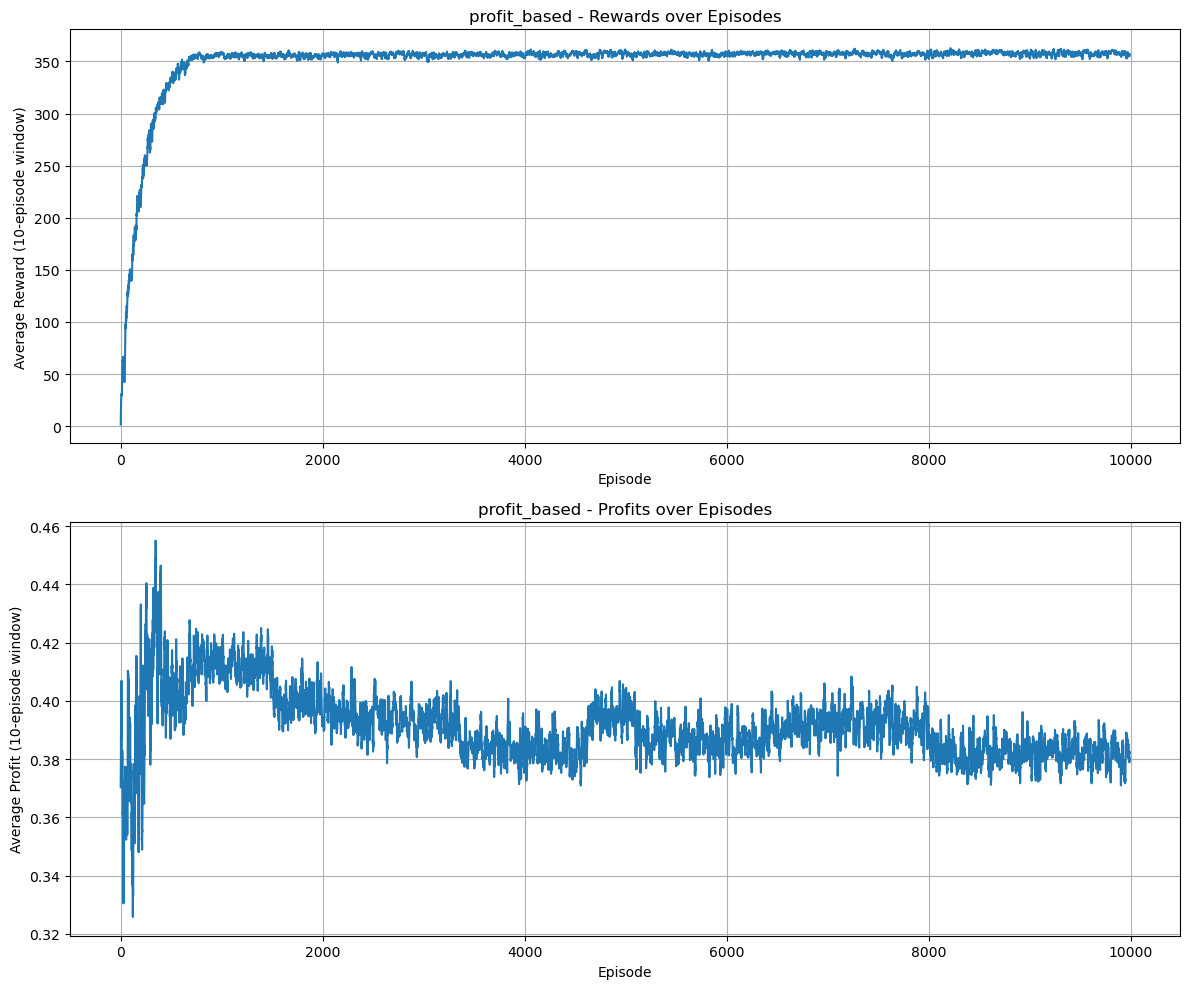

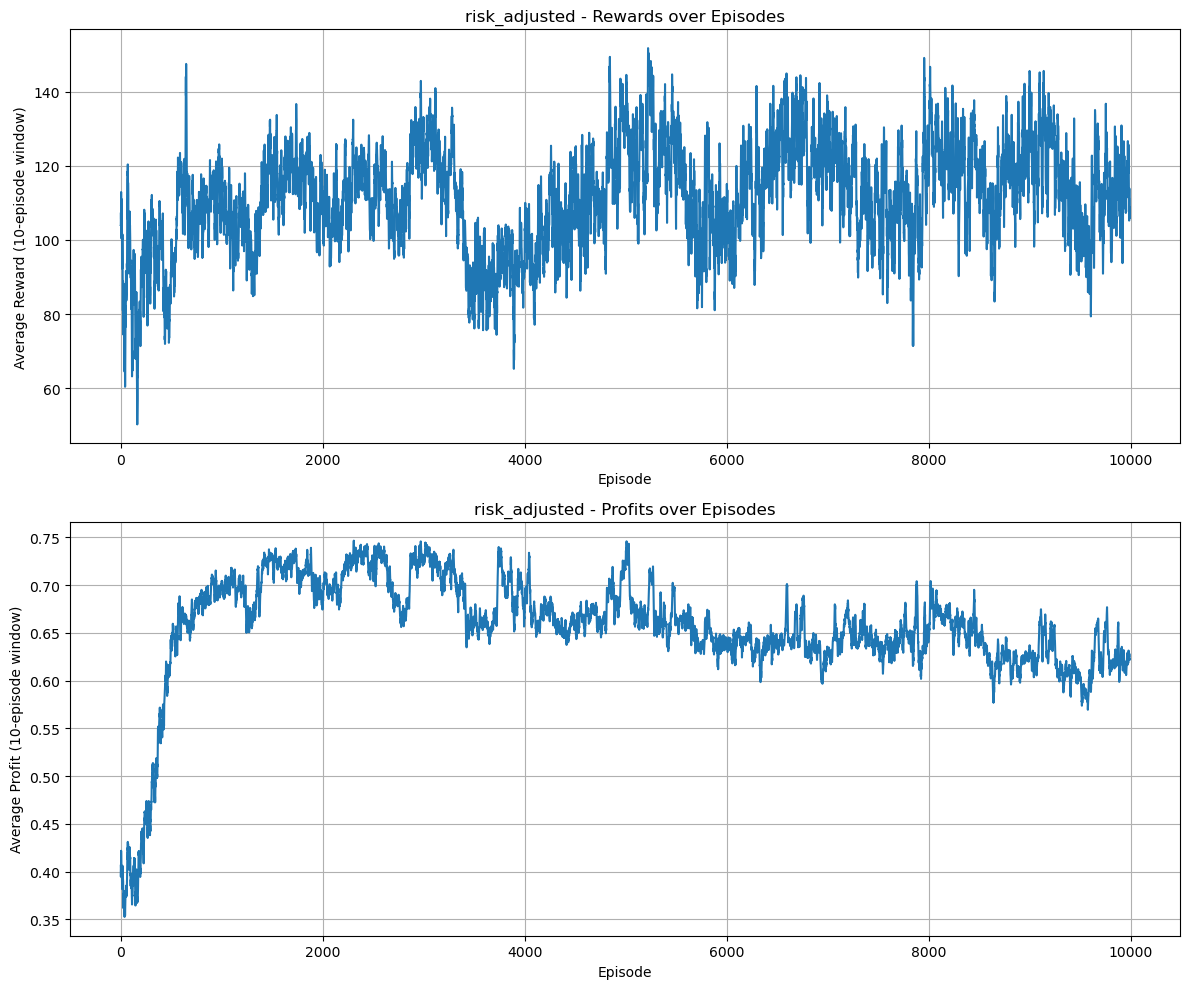

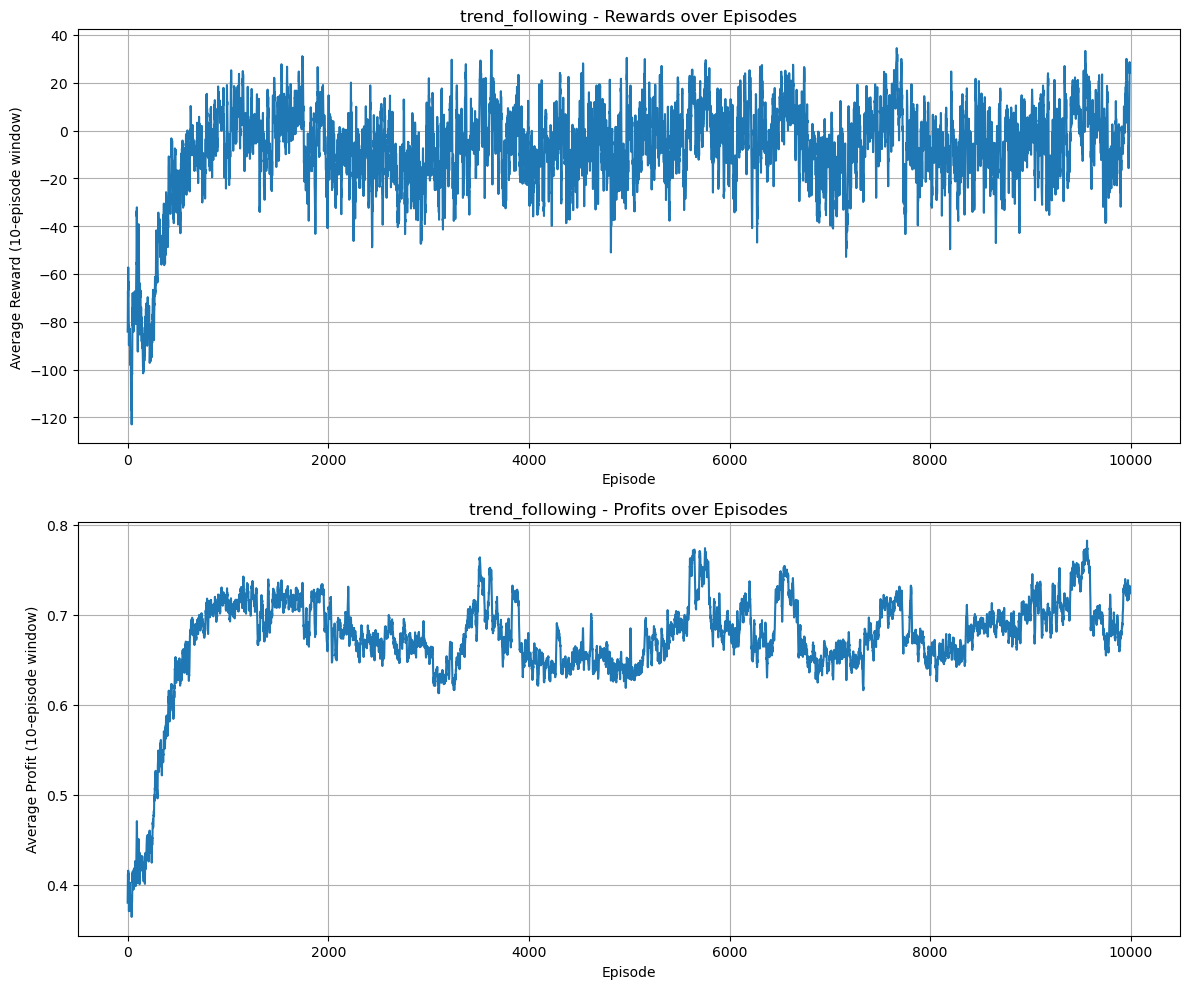

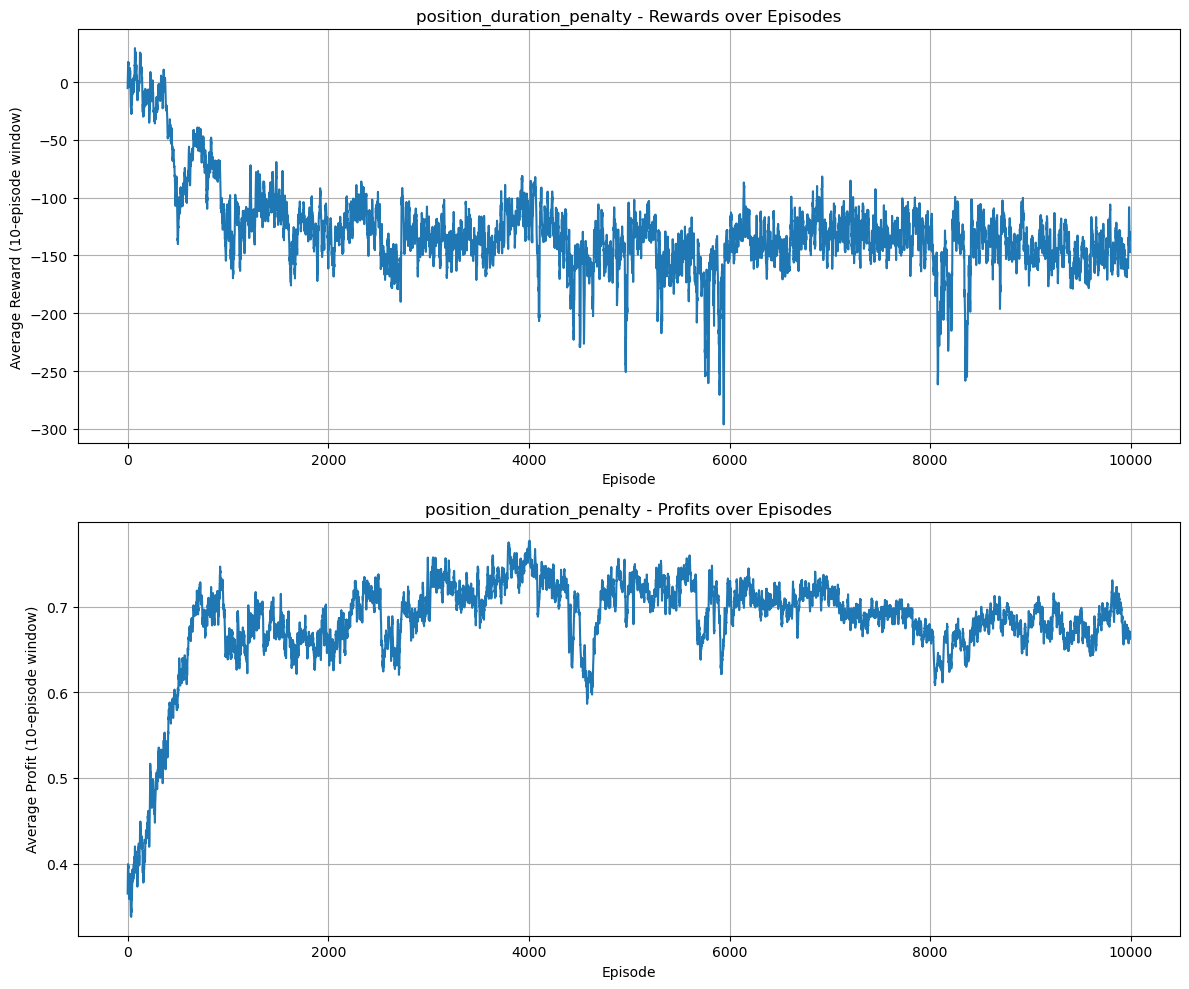


=== Final Performance Metrics (Last 100 Episodes) ===

                           avg_reward  avg_profit  max_profit  min_profit  \
default                     51.680530    0.740454    0.823355    0.642892   
profit_based               356.983382    0.380879    0.410660    0.335202   
risk_adjusted              113.937598    0.620940    0.693565    0.542996   
trend_following              4.300262    0.716071    0.773532    0.645831   
position_duration_penalty -150.505439    0.674162    0.752463    0.591995   

                           std_profit  sharpe_ratio  
default                      0.032390     -8.012948  
profit_based                 0.013880    -44.602751  
risk_adjusted                0.021701    -17.466489  
trend_following              0.032606     -8.707702  
position_duration_penalty    0.029571    -11.018569  

Best reward structure based on Sharpe ratio: default

=== Test Performance ===

total_reward: 4.1292
final_profit: 0.7473
max_profit: 1.0059


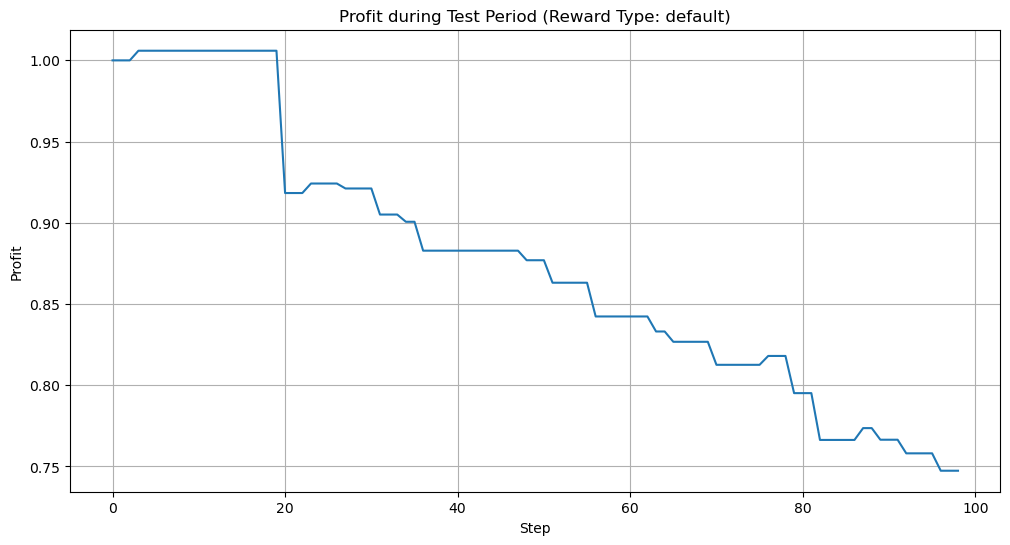

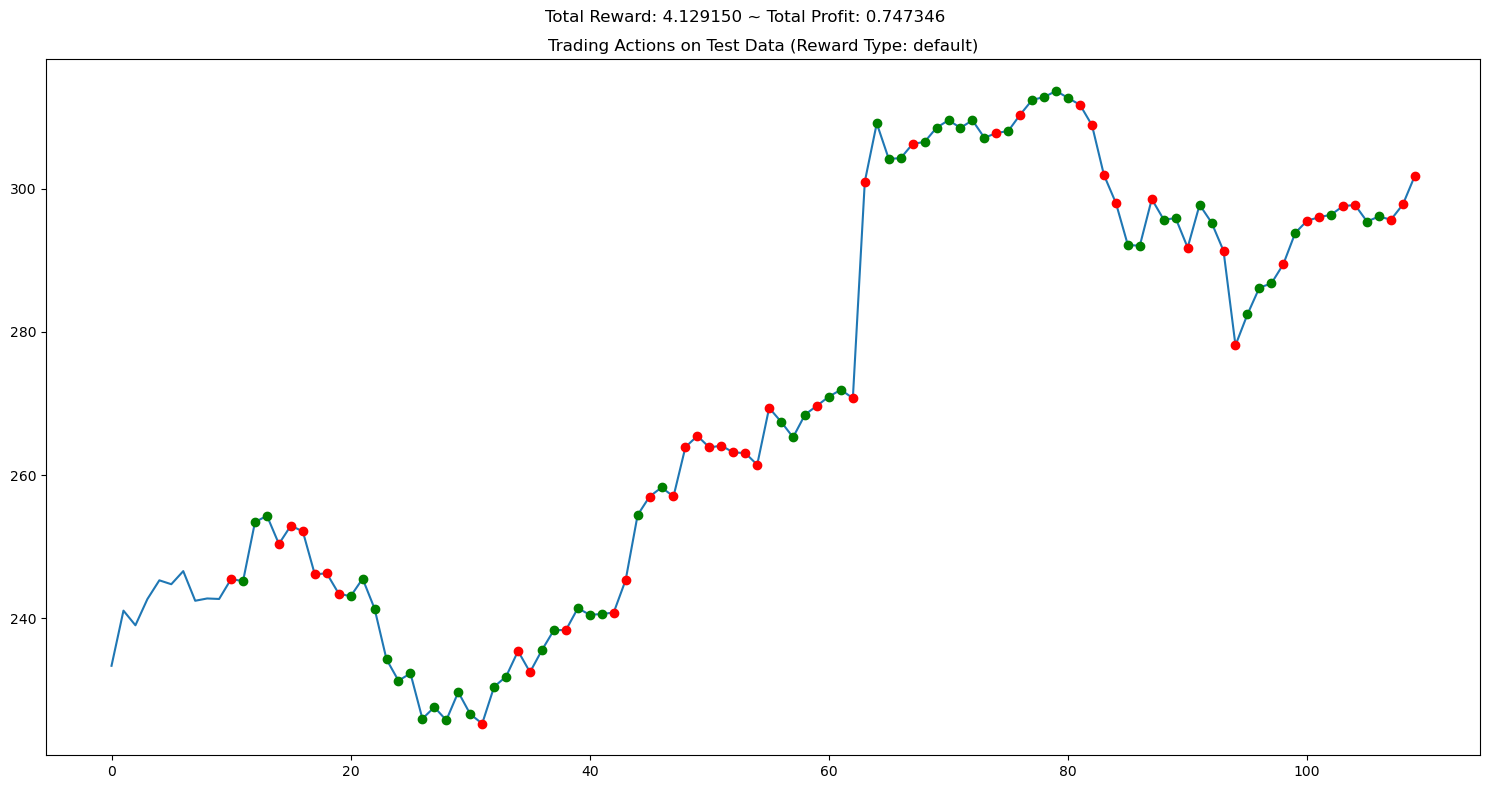

In [16]:
class RewardWrapper:
    """
    A wrapper class to modify the reward structure of the trading environment
    """
    def __init__(self, env, reward_type='default'):
        """
        Initialize the reward wrapper
        
        Args:
            env: The trading environment
            reward_type: Type of reward structure to use
        """
        self.env = env
        self.reward_type = reward_type
        self.price_history = []
        self.position_duration = 0
        self.last_position = None
        
    def reset(self):
        """Reset the wrapper state"""
        observation, info = self.env.reset()
        self.price_history = []
        self.position_duration = 0
        self.last_position = None
        return observation, info
    
    def step(self, action):
        """
        Take a step in the environment and modify the reward
        
        Args:
            action: The action to take
            
        Returns:
            Modified (observation, reward, done, info) tuple
        """
        observation, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        
        # Store current price
        current_price = self.env.unwrapped.prices[self.env.unwrapped._current_tick]
        self.price_history.append(current_price)
        
        # Track position duration
        current_position = self.env.unwrapped._position
        if self.last_position is None:
            self.last_position = current_position
        
        if current_position == self.last_position:
            self.position_duration += 1
        else:
            self.position_duration = 0
            self.last_position = current_position
        
        # Calculate modified reward based on the selected reward type
        modified_reward = self._calculate_reward(reward, action, info, done)
        
        return observation, modified_reward, terminated, truncated, info
    
    def _calculate_reward(self, original_reward, action, info, done):
        """
        Calculate the modified reward based on the selected reward type
        
        Args:
            original_reward: The original reward from the environment
            action: The action taken
            info: Additional information from the environment
            done: Whether the episode is done
            
        Returns:
            The modified reward
        """
        if self.reward_type == 'default':
            return original_reward
        
        elif self.reward_type == 'profit_based':
            # Reward based on profit percentage
            if 'total_profit' in info and len(self.price_history) > 1:
                # Calculate profit percentage since last step
                if len(self.price_history) >= 2:
                    prev_profit = (self.price_history[-2] / self.price_history[0]) if self.env.unwrapped._position == Positions.Long else (2 - self.price_history[-2] / self.price_history[0])
                    curr_profit = (self.price_history[-1] / self.price_history[0]) if self.env.unwrapped._position == Positions.Long else (2 - self.price_history[-1] / self.price_history[0])
                    profit_change = (curr_profit - prev_profit) * 100  # Convert to percentage
                    return profit_change
            return original_reward
        
        elif self.reward_type == 'risk_adjusted':
            # Risk-adjusted reward (Sharpe ratio inspired)
            if len(self.price_history) > 10:
                # Calculate returns - fix the shape mismatch
                prices = np.array(self.price_history[-10:])
                prev_prices = np.array(self.price_history[-11:-1])
                returns = (prices - prev_prices) / prev_prices
                
                # Calculate mean and std of returns
                mean_return = np.mean(returns)
                std_return = np.std(returns) + 1e-6  # Add small value to avoid division by zero
                
                # Calculate Sharpe-like ratio
                sharpe = mean_return / std_return
                
                # Combine with original reward
                return original_reward * (1 + sharpe)
            return original_reward
        
        elif self.reward_type == 'trend_following':
            # Reward that encourages following the market trend
            if len(self.price_history) > 5:
                # Calculate short-term trend
                short_trend = np.mean(np.diff(self.price_history[-5:]))
                
                # Reward for following trend
                if (short_trend > 0 and self.env.unwrapped._position == Positions.Long) or \
                    (short_trend < 0 and self.env.unwrapped._position == Positions.Short):
                        return original_reward * 1.5  # Bonus for following trend
                else:
                    return original_reward * 0.5  # Penalty for going against trend
            return original_reward
        
        elif self.reward_type == 'position_duration_penalty':
            # Penalize holding positions for too long
            duration_penalty = 0.05 * self.position_duration  # 5% penalty per step
            return original_reward - duration_penalty
        
        else:
            return original_reward

## 4. Training and Evaluation Function

def train_and_evaluate(env, reward_type, num_episodes=1000, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.02):
    """
    Train a Q-learning agent and evaluate its performance
    
    Args:
        env: The trading environment
        reward_type: Type of reward structure to use
        num_episodes: Number of episodes to train
        learning_rate: Learning rate for Q-learning
        discount_factor: Discount factor for future rewards
        exploration_rate: Initial exploration rate
        exploration_decay: Rate at which exploration rate decays
        min_exploration_rate: Minimum exploration rate
        
    Returns:
        Tuple of (rewards_history, profits_history, trained_agent)
    """
    # Create reward wrapper
    wrapped_env = RewardWrapper(env, reward_type=reward_type)
    
    # Get observation space dimensions
    observation_shape = env.observation_space.shape
    
    # Define discretization parameters
    # For price values (first column)
    price_lower = 190  # Based on GOOGL data minimum
    price_upper = 320  # Based on GOOGL data maximum
    price_bins = 20    # Number of bins
    
    # For price differences (second column)
    diff_lower = -20   # Adjusted for GOOGL data
    diff_upper = 20    # Adjusted for GOOGL data
    diff_bins = 20     # Number of bins
    
    # Create discretizer with appropriate dimensions for the last row of observation
    lower_bounds = np.array([price_lower, diff_lower])
    upper_bounds = np.array([price_upper, diff_upper])
    num_bins = np.array([price_bins, diff_bins])
    
    discretizer = Discretizer(lower_bounds, upper_bounds, num_bins)
    
    # Create Q-learning agent
    agent = QLearningAgent(
        env.action_space,
        discretizer,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        exploration_decay=exploration_decay,
        min_exploration_rate=min_exploration_rate
    )
    
    # Training loop
    rewards_history = []
    profits_history = []
    
    for episode in range(1, num_episodes + 1):
        # Reset environment
        observation, info = wrapped_env.reset()
        done = False
        episode_reward = 0
        
        # Episode loop
        while not done:
            # Choose action
            action = agent.get_action(observation)
            
            # Take action
            next_observation, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated
            
            # Update Q-table
            agent.update(observation, action, reward, next_observation, done)
            
            # Update current observation
            observation = next_observation
            
            # Accumulate reward
            episode_reward += reward
        
        # Store episode results
        rewards_history.append(episode_reward)
        profits_history.append(info['total_profit'])
        
        # Print progress
        if episode % 10 == 0:
            avg_reward = np.mean(rewards_history[-10:])
            avg_profit = np.mean(profits_history[-10:])
            print(f"Episode {episode}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Avg Profit: {avg_profit:.4f}, Exploration Rate: {agent.exploration_rate:.4f}")
    
    return rewards_history, profits_history, agent

## 5. Experiment with Different Reward Structures

# Create environment
env = gym.make('stocks-v0', df=STOCKS_GOOGL, window_size=10, frame_bound=(10, 300))

# Define reward types to test
reward_types = ['default', 'profit_based', 'risk_adjusted', 'trend_following', 'position_duration_penalty']

# Store results
all_rewards = {}
all_profits = {}
all_agents = {}

# Train and evaluate with each reward type
for reward_type in reward_types:
    print(f"\n=== Training with {reward_type} reward structure ===\n")
    rewards, profits, agent = train_and_evaluate(
        env, 
        reward_type=reward_type,
        num_episodes=10000,
        learning_rate=0.1,
        discount_factor=0.99,
        exploration_rate=1.0,
        exploration_decay=0.995,
        min_exploration_rate=0.02
    )
    
    all_rewards[reward_type] = rewards
    all_profits[reward_type] = profits
    all_agents[reward_type] = agent

## 6. Visualize and Compare Results

# Create results directory if it doesn't exist
import os
results_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'results', 'reward_structures')
os.makedirs(results_dir, exist_ok=True)

# Plot rewards
plt.figure(figsize=(12, 6))
for reward_type, rewards in all_rewards.items():
    # Apply smoothing for better visualization
    smoothed_rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(smoothed_rewards, label=reward_type)

plt.title('Smoothed Rewards over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Reward (10-episode window)')
plt.legend()
plt.grid(True)
# Save the rewards plot
plt.savefig(os.path.join(results_dir, 'rewards_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot profits
plt.figure(figsize=(12, 6))
for reward_type, profits in all_profits.items():
    # Apply smoothing for better visualization
    smoothed_profits = np.convolve(profits, np.ones(10)/10, mode='valid')
    plt.plot(smoothed_profits, label=reward_type)

plt.title('Smoothed Profits over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Profit (10-episode window)')
plt.legend()
plt.grid(True)
# Save the profits plot
plt.savefig(os.path.join(results_dir, 'profits_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create individual plots for each reward structure
for reward_type in reward_types:
    plt.figure(figsize=(12, 10))
    
    # Plot rewards
    plt.subplot(2, 1, 1)
    smoothed_rewards = np.convolve(all_rewards[reward_type], np.ones(10)/10, mode='valid')
    plt.plot(smoothed_rewards)
    plt.title(f'{reward_type} - Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (10-episode window)')
    plt.grid(True)
    
    # Plot profits
    plt.subplot(2, 1, 2)
    smoothed_profits = np.convolve(all_profits[reward_type], np.ones(10)/10, mode='valid')
    plt.plot(smoothed_profits)
    plt.title(f'{reward_type} - Profits over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average Profit (10-episode window)')
    plt.grid(True)
    
    plt.tight_layout()
    # Save individual reward structure plot
    plt.savefig(os.path.join(results_dir, f'{reward_type}_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Calculate final performance metrics
final_metrics = {}

for reward_type in reward_types:
    # Calculate metrics on the last 100 episodes
    final_rewards = all_rewards[reward_type][-100:]
    final_profits = all_profits[reward_type][-100:]
    
    metrics = {
        'avg_reward': np.mean(final_rewards),
        'avg_profit': np.mean(final_profits),
        'max_profit': np.max(final_profits),
        'min_profit': np.min(final_profits),
        'std_profit': np.std(final_profits),
        'sharpe_ratio': (np.mean(final_profits) - 1.0) / (np.std(final_profits) + 1e-6)  # Simplified Sharpe ratio
    }
    
    final_metrics[reward_type] = metrics

# Display final metrics
import pandas as pd
metrics_df = pd.DataFrame(final_metrics).T
print("\n=== Final Performance Metrics (Last 100 Episodes) ===\n")
print(metrics_df)

## 7. Test Best Agent on Unseen Data

# Find the best performing reward structure based on Sharpe ratio
best_reward_type = max(final_metrics, key=lambda x: final_metrics[x]['sharpe_ratio'])
print(f"\nBest reward structure based on Sharpe ratio: {best_reward_type}")

# Create a test environment with unseen data
test_env = gym.make('stocks-v0', df=STOCKS_GOOGL, window_size=10, frame_bound=(300, 400))

# Get the best agent
best_agent = all_agents[best_reward_type]

# Evaluate on test data
observation, info = test_env.reset()
done = False
test_rewards = []
test_profits = []

while not done:
    # Discretize the observation
    state = best_agent.discretizer.discretize(observation)
    
    # Choose the best action from Q-table (no exploration)
    if state in best_agent.q_table:
        action = np.argmax(best_agent.q_table[state])
    else:
        action = test_env.action_space.sample()
    
    # Take action
    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    
    # Store results
    test_rewards.append(reward)
    if 'total_profit' in info:
        test_profits.append(info['total_profit'])

# Calculate test performance
test_performance = {
    'total_reward': sum(test_rewards),
    'final_profit': test_profits[-1] if test_profits else 0,
    'max_profit': max(test_profits) if test_profits else 0
}

print("\n=== Test Performance ===\n")
for metric, value in test_performance.items():
    print(f"{metric}: {value:.4f}")

# Visualize test performance
plt.figure(figsize=(12, 6))
plt.plot(test_profits)
plt.title(f'Profit during Test Period (Reward Type: {best_reward_type})')
plt.xlabel('Step')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

# Render the test environment
plt.figure(figsize=(15, 8))
test_env.unwrapped.render_all()
plt.title(f'Trading Actions on Test Data (Reward Type: {best_reward_type})')
plt.tight_layout()
plt.show()